In [1]:
# Cell 1: Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import joblib
import json
from datetime import datetime, timedelta
import warnings
import os
import glob
import re
import logging
from pathlib import Path
import tempfile
import zipfile
import io
from typing import Dict, List, Any, Optional, Tuple
import shutil
from IPython.display import display, HTML, Image
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('rtgs_system.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Configuration class and directory setup
class Config:
    """Configuration class for the RTGS system with enhanced visualization settings"""
    
    
    DATA_PATH = r"C:\Users\maverick\TECHBHARAT\TECHBHARAT CLEAN DATA FILE.csv"
    OUTPUT_DIR = "rtgs_outputs"
    
    
    DATE_FORMAT = "%Y-%m-%d"
    STANDARDIZED_COLUMNS = {
        'rainfall': 'rain_mm',
        'temperature': 'temp_c',
        'humidity': 'humidity_pct',
        'wind': 'wind_kmph'
    }
    
   
    OUTLIER_THRESHOLD = 3  
    MISSING_DATA_THRESHOLD = 0.3 
    
   
    RISK_THRESHOLDS = {
        'low': 30,
        'medium': 70,
        'high': 100
    }
    
   
    COLORS = {
        'low_risk': '#2ecc71',    # Green
        'medium_risk': '#f39c12', # Orange
        'high_risk': '#e74c3c',   # Red
        'rainfall': '#3498db',    # Blue
        'temperature': '#e74c3c', # Red
        'humidity': '#9b59b6',    # Purple
        'wind': '#34495e'         # Dark blue
    }
    
   
    CHART_WIDTH = 1000
    CHART_HEIGHT = 600
    MAP_SETTINGS = {
        'center': {'lat': 17.1232, 'lon': 79.2088},  # Center of Telangana
        'zoom': 6,
        'style': 'open-street-map'
    }
    
   
    JOIN_KEYS = ['district', 'date', 'season']
    
    
    MODEL_PARAMS = {
        'n_estimators': 100,
        'max_depth': 10,
        'random_state': 42
    }
    
   
    INTERACTIVE_FILTERS = {
        'district': 'All',
        'season': 'All',
        'year_range': [2010, 2023],
        'risk_level': 'All'
    }

def setup_directories():
    """Create all necessary output directories"""
    directories = [
        Config.OUTPUT_DIR,
        f"{Config.OUTPUT_DIR}/standardized",
        f"{Config.OUTPUT_DIR}/cleaned", 
        f"{Config.OUTPUT_DIR}/insights",
        f"{Config.OUTPUT_DIR}/logs",
        f"{Config.OUTPUT_DIR}/visualizations",
        f"{Config.OUTPUT_DIR}/models",
        f"{Config.OUTPUT_DIR}/reports",
        f"{Config.OUTPUT_DIR}/exports",
        f"{Config.OUTPUT_DIR}/interactive"
    ]

    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        logger.info(f"Created directory: {directory}")


setup_directories()
print("Configuration and directories set up successfully!")

2025-09-07 19:36:12,054 - INFO - Created directory: rtgs_outputs
2025-09-07 19:36:12,068 - INFO - Created directory: rtgs_outputs/standardized
2025-09-07 19:36:12,069 - INFO - Created directory: rtgs_outputs/cleaned
2025-09-07 19:36:12,070 - INFO - Created directory: rtgs_outputs/insights
2025-09-07 19:36:12,071 - INFO - Created directory: rtgs_outputs/logs
2025-09-07 19:36:12,071 - INFO - Created directory: rtgs_outputs/visualizations
2025-09-07 19:36:12,072 - INFO - Created directory: rtgs_outputs/models
2025-09-07 19:36:12,073 - INFO - Created directory: rtgs_outputs/reports
2025-09-07 19:36:12,073 - INFO - Created directory: rtgs_outputs/exports
2025-09-07 19:36:12,074 - INFO - Created directory: rtgs_outputs/interactive


Configuration and directories set up successfully!


In [3]:
# Cell 3: Dataset analysis functions
def get_dataset_info(file_path: str) -> Dict[str, Any]:
    """Get comprehensive information about the dataset with visual analysis"""
    logger.info(f"Analyzing dataset: {file_path}")
    
    try:
        
        df_sample = pd.read_csv(file_path, nrows=10000)
        
       
        info = {
            'file_path': file_path,
            'size_mb': os.path.getsize(file_path) / (1024 * 1024),
            'total_rows': sum(1 for line in open(file_path, encoding="utf-8")) - 1,
            'sample_rows': len(df_sample),
            'columns': list(df_sample.columns),
            'dtypes': {col: str(dtype) for col, dtype in df_sample.dtypes.to_dict().items()},
            'date_columns': [col for col in df_sample.columns if 'date' in col.lower()],
            'numeric_columns': df_sample.select_dtypes(include=[np.number]).columns.tolist(),
            'categorical_columns': df_sample.select_dtypes(include=['object']).columns.tolist(),
            'missing_values': df_sample.isnull().sum().to_dict(),
            'memory_usage_mb': df_sample.memory_usage(deep=True).sum() / (1024 * 1024)
        }
        
       
        create_data_structure_visualizations(df_sample, info)
        
        
        with open(f"{Config.OUTPUT_DIR}/logs/dataset_info.json", 'w') as f:
            json.dump(info, f, indent=4)
            
        logger.info(f"Dataset analysis complete. Found {info['total_rows']} rows and {len(info['columns'])} columns.")
        return info
        
    except Exception as e:
        logger.error(f"Error analyzing dataset: {str(e)}")
        raise

def create_data_structure_visualizations(df_sample: pd.DataFrame, info: Dict[str, Any]):
    """Create visualizations showing data structure and quality"""
    
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    
    dtype_counts = df_sample.dtypes.value_counts()
    axes[0, 0].pie(dtype_counts.values, labels=dtype_counts.index.astype(str), autopct='%1.1f%%')
    axes[0, 0].set_title('Data Types Distribution')
    
    
    missing_values = df_sample.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if len(missing_values) > 0:
        axes[0, 1].bar(range(len(missing_values)), missing_values.values)
        axes[0, 1].set_xticks(range(len(missing_values)))
        axes[0, 1].set_xticklabels(missing_values.index, rotation=45, ha='right')
        axes[0, 1].set_title('Missing Values by Column')
        axes[0, 1].set_ylabel('Missing Count')
    
  
    if info['numeric_columns']:
        numeric_data = df_sample[info['numeric_columns']].describe().T
        axes[1, 0].scatter(numeric_data['mean'], numeric_data['std'], alpha=0.5)
        for i, col in enumerate(numeric_data.index):
            axes[1, 0].annotate(col, (numeric_data['mean'].iloc[i], numeric_data['std'].iloc[i]))
        axes[1, 0].set_xlabel('Mean')
        axes[1, 0].set_ylabel('Standard Deviation')
        axes[1, 0].set_title('Numeric Columns: Mean vs Standard Deviation')
    

    if info['categorical_columns']:
        cardinality = [df_sample[col].nunique() for col in info['categorical_columns']]
        axes[1, 1].bar(range(len(cardinality)), cardinality)
        axes[1, 1].set_xticks(range(len(cardinality)))
        axes[1, 1].set_xticklabels(info['categorical_columns'], rotation=45, ha='right')
        axes[1, 1].set_title('Categorical Columns Cardinality')
        axes[1, 1].set_ylabel('Unique Values Count')
    
    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/data_structure_analysis.png", dpi=300, bbox_inches='tight')
    plt.close()
    
   
    if len(info['numeric_columns']) > 1:
        corr_matrix = df_sample[info['numeric_columns']].corr()
        fig = px.imshow(corr_matrix, 
                       title='Correlation Matrix of Numeric Features',
                       color_continuous_scale='RdBu_r',
                       aspect='auto')
        fig.write_html(f"{Config.OUTPUT_DIR}/visualizations/correlation_matrix.html")
        
        # Also save as static image
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/correlation_matrix.png", dpi=300, bbox_inches='tight')
        plt.close()

print("Dataset analysis functions defined successfully!")

Dataset analysis functions defined successfully!


In [4]:
# Cell 4: Data standardization functions
def get_season(month: int) -> str:
    """Get season from month number"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

def load_and_standardize_data(file_path: str) -> pd.DataFrame:
    """Load and standardize the dataset with progress tracking and validation"""
    logger.info("Loading and standardizing data...")
    
 
    progress_data = {
        'start_time': datetime.now(),
        'steps': [],
        'issues_found': []
    }
    
    try:
       
        chunk_size = 100000
        chunks = []
        total_rows = sum(1 for line in open(file_path, encoding="utf-8")) - 1
        
        for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)):
            chunks.append(chunk)
            progress = min((i + 1) * chunk_size / total_rows * 100, 100)
            if i % 10 == 0:  # Log every 10 chunks
                logger.info(f"Loading data: {progress:.1f}% complete")
        
        df = pd.concat(chunks, ignore_index=True)
        original_shape = df.shape
        progress_data['steps'].append({
            'step': 'data_loading',
            'status': 'completed',
            'rows_loaded': len(df),
            'timestamp': datetime.now().isoformat()
        })
        
        logger.info(f"Original data shape: {original_shape}")
        
     
        df.columns = [col.lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
        
    
        date_cols = [col for col in df.columns if 'date' in col]
        if date_cols:
            date_col = date_cols[0]
            for date_format in ['%Y-%m-%d', '%d-%m-%Y', '%m/%d/%Y', '%Y/%m/%d', '%d-%b-%y', '%d/%m/%y']:
                try:
                    df['date'] = pd.to_datetime(df[date_col], format=date_format, errors='raise')
                    break
                except:
                    continue
            else:
                
                df['date'] = pd.to_datetime(df[date_col], errors='coerce')
                progress_data['issues_found'].append('date_parsing_used_coercion')
            
            
            invalid_dates = df['date'].isna().sum()
            if invalid_dates > 0:
                df = df.dropna(subset=['date'])
                progress_data['issues_found'].append(f'dropped_{invalid_dates}_invalid_dates')
        
        
        time_features_added = []
        if 'date' in df.columns:
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day'] = df['date'].dt.day
            df['day_of_year'] = df['date'].dt.dayofyear
            df['week_of_year'] = df['date'].dt.isocalendar().week
            df['quarter'] = df['date'].dt.quarter
            df['season'] = df['month'].apply(get_season)
            time_features_added = ['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']
        
        
        if 'district' in df.columns:
            df['district'] = df['district'].str.title().str.strip()
            district_stats = {
                'unique_districts': df['district'].nunique(),
                'most_common_district': df['district'].mode().iloc[0] if len(df['district'].mode()) > 0 else None
            }
            progress_data['district_stats'] = district_stats
        
        
        numeric_indicators = ['rain', 'temp', 'humidity', 'wind']
        conversion_issues = {}
        
        for col in df.columns:
            for indicator in numeric_indicators:
                if indicator in col and df[col].dtype == 'object':
                    try:
                        
                        original_non_null = df[col].notna().sum()
                        
                      
                        df[col] = pd.to_numeric(df[col].astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')
                        
                       
                        new_non_null = df[col].notna().sum()
                        if new_non_null < original_non_null:
                            conversion_issues[col] = original_non_null - new_non_null
                    except Exception as e:
                        progress_data['issues_found'].append(f'conversion_error_{col}: {str(e)}')
        
        if conversion_issues:
            progress_data['conversion_issues'] = conversion_issues
        
        
        df.to_parquet(f"{Config.OUTPUT_DIR}/standardized/data_standardized.parquet", index=False)
        df.to_csv(f"{Config.OUTPUT_DIR}/standardized/data_standardized.csv", index=False)
        
        logger.info(f"Standardization complete. Final shape: {df.shape}")
        
        
        standardization_report = {
            'original_shape': original_shape,
            'final_shape': df.shape,
            'columns_standardized': list(df.columns),
            'time_features_added': time_features_added,
            'date_range': {
                'start': df['date'].min().strftime(Config.DATE_FORMAT) if 'date' in df.columns else None,
                'end': df['date'].max().strftime(Config.DATE_FORMAT) if 'date' in df.columns else None
            },
            'districts': sorted(df['district'].unique()) if 'district' in df.columns else [],
            'missing_values_post_standardization': df.isnull().sum().to_dict(),
            'data_quality_issues': progress_data['issues_found'],
            'processing_time_seconds': (datetime.now() - progress_data['start_time']).total_seconds()
        }
        
        with open(f"{Config.OUTPUT_DIR}/logs/standardization_report.json", 'w') as f:
            json.dump(standardization_report, f, indent=4)
        
      
        create_standardization_visualization(df, standardization_report)
        
        return df
        
    except Exception as e:
        logger.error(f"Error in standardization process: {str(e)}")
        progress_data['steps'].append({
            'step': 'error',
            'error_message': str(e),
            'timestamp': datetime.now().isoformat()
        })
        raise

def create_standardization_visualization(df: pd.DataFrame, report: Dict[str, Any]):
    """Create visualizations showing the standardization process"""
    
   
    if 'missing_values_pre_clean' in report and 'missing_values_post_standardization' in report:
        missing_before = report['missing_values_pre_clean']
        missing_after = report['missing_values_post_standardization']
        
       
        columns = list(missing_before.keys())
        before_vals = [missing_before[col] for col in columns]
        after_vals = [missing_after[col] for col in columns]
        
        x = np.arange(len(columns))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 8))
        rects1 = ax.bar(x - width/2, before_vals, width, label='Before Standardization', alpha=0.8)
        rects2 = ax.bar(x + width/2, after_vals, width, label='After Standardization', alpha=0.8)
        
        ax.set_xlabel('Columns')
        ax.set_ylabel('Missing Values Count')
        ax.set_title('Missing Values Before and After Standardization')
        ax.set_xticks(x)
        ax.set_xticklabels(columns, rotation=45, ha='right')
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/missing_values_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    
    if 'date' in df.columns:
        time_series_data = df.groupby('date').size().reset_index(name='count')
        
        fig = px.line(time_series_data, x='date', y='count', 
                     title='Data Points Over Time',
                     labels={'count': 'Number of Records', 'date': 'Date'})
        fig.write_html(f"{Config.OUTPUT_DIR}/visualizations/temporal_coverage.html")
        
       
        if 'season' in df.columns:
            seasonal_data = df.groupby(['year', 'season']).size().unstack(fill_value=0)
            plt.figure(figsize=(12, 8))
            seasonal_data.plot(kind='bar', stacked=True)
            plt.title('Data Distribution by Season and Year')
            plt.xlabel('Year')
            plt.ylabel('Number of Records')
            plt.legend(title='Season')
            plt.tight_layout()
            plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/seasonal_distribution.png", dpi=300, bbox_inches='tight')
            plt.close()

print("Data standardization functions defined successfully!")


Data standardization functions defined successfully!


In [5]:
# Cell 5: Data cleaning and transformation functions
def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create advanced derived features for analysis"""
    df = df.copy()
    

    if 'temp_min' in df.columns and 'temp_max' in df.columns:
        df['avg_temp'] = (df['temp_min'] + df['temp_max']) / 2
    
    if 'humidity_min' in df.columns and 'humidity_max' in df.columns:
        df['avg_humidity'] = (df['humidity_min'] + df['humidity_max']) / 2
        
    if 'wind_min' in df.columns and 'wind_max' in df.columns:
        df['avg_wind'] = (df['wind_min'] + df['wind_max']) / 2
    
    
    if 'rainfall_mm' in df.columns and 'district' in df.columns and 'date' in df.columns:
        df = df.sort_values(['district', 'date'])
        df['rolling_avg_rainfall_7d'] = df.groupby('district')['rainfall_mm'].transform(
            lambda x: x.rolling(window=7, min_periods=1).mean()
        )
        df['rolling_avg_rainfall_30d'] = df.groupby('district')['rainfall_mm'].transform(
            lambda x: x.rolling(window=30, min_periods=1).mean()
        )
    
  
    if 'rainfall_mm' in df.columns and 'district' in df.columns and 'season' in df.columns:
        seasonal_rainfall = df.groupby(['district', 'season'])['rainfall_mm'].mean().reset_index()
        seasonal_rainfall.rename(columns={'rainfall_mm': 'seasonal_avg_rainfall'}, inplace=True)
        df = df.merge(seasonal_rainfall, on=['district', 'season'], how='left')
    
   
    if 'rainfall_mm' in df.columns and 'seasonal_avg_rainfall' in df.columns:
        df['rainfall_anomaly'] = df['rainfall_mm'] - df['seasonal_avg_rainfall']
        df['rainfall_anomaly_pct'] = (df['rainfall_anomaly'] / df['seasonal_avg_rainfall']) * 100
    
  
    if 'rainfall_mm' in df.columns:
        df['heavy_rain_flag'] = (df['rainfall_mm'] > 50).astype(int)
    
    if 'avg_temp' in df.columns:
        df['heatwave_flag'] = (df['avg_temp'] > 35).astype(int)
    
 
    if 'rainfall_mm' in df.columns and 'district' in df.columns and 'date' in df.columns:
        df = df.sort_values(['district', 'date'])
        df['dry_day'] = (df['rainfall_mm'] < 1).astype(int)
        df['dry_spell_length'] = df.groupby('district')['dry_day'].transform(
            lambda x: x * (x.groupby((x != x.shift()).cumsum()).cumcount() + 1)
        )
    
    return df

def create_enhanced_risk_indices(df: pd.DataFrame) -> pd.DataFrame:
    """Create enhanced risk indices for agricultural assessment"""
    df = df.copy()
    
    
    risk_factors = {}
    
    if 'rainfall_mm' in df.columns:
        # Calculate rainfall risk (both deficit and excess)
        df['rainfall_risk'] = np.where(
            df['rainfall_mm'] < 5,  # Drought risk
            (5 - df['rainfall_mm']) / 5 * 50,  # Scale 0-50 for drought
            np.where(
                df['rainfall_mm'] > 50,  # Flood risk
                (df['rainfall_mm'] - 50) / 50 * 50,  # Scale 0-50 for flood
                0  # No risk
            )
        )
        risk_factors['rainfall_risk'] = 0.4  # Weight
    
    if 'avg_temp' in df.columns:
        # Calculate temperature risk (heat stress)
        df['temperature_risk'] = np.where(
            df['avg_temp'] > 30,
            (df['avg_temp'] - 30) / 10 * 50,  # Scale 0-50 for heat stress
            0
        )
        risk_factors['temperature_risk'] = 0.3  # Weight
    
    if 'avg_humidity' in df.columns:
        # Calculate humidity risk (both low and high)
        df['humidity_risk'] = np.where(
            df['avg_humidity'] < 40,  # Too dry
            (40 - df['avg_humidity']) / 40 * 25,  # Scale 0-25 for dry
            np.where(
                df['avg_humidity'] > 80,  # Too humid
                (df['avg_humidity'] - 80) / 20 * 25,  # Scale 0-25 for humid
                0
            )
        )
        risk_factors['humidity_risk'] = 0.2  # Weight
    
    if 'dry_spell_length' in df.columns:
        # Calculate dry spell risk
        df['dry_spell_risk'] = np.where(
            df['dry_spell_length'] > 7,
            np.minimum((df['dry_spell_length'] - 7) / 7 * 50, 50),  # Scale 0-50
            0
        )
        risk_factors['dry_spell_risk'] = 0.1  
    
    
    ari_components = []
    for factor, weight in risk_factors.items():
        if factor in df.columns:
            ari_components.append(df[factor] * weight)
    
    if ari_components:
        df['ari'] = sum(ari_components)
        
       
        df['ari_normalized'] = (df['ari'] - df['ari'].min()) / (df['ari'].max() - df['ari'].min()) * 100
        
       
        df['risk_category'] = pd.cut(
            df['ari_normalized'],
            bins=[0, 30, 70, 100],
            labels=['Low', 'Medium', 'High'],
            include_lowest=True
        )
    
    return df

def add_quality_flags(df: pd.DataFrame) -> pd.DataFrame:
    """Add data quality flags to the dataset"""
    df = df.copy()
    
   
    required_cols = ['district', 'date', 'rainfall_mm']
    df['data_completeness'] = df[required_cols].notnull().mean(axis=1) * 100
    
   
    if 'temp_min' in df.columns and 'temp_max' in df.columns:
        df['temp_consistency_flag'] = (df['temp_min'] <= df['temp_max']).astype(int)
    
    if 'humidity_min' in df.columns and 'humidity_max' in df.columns:
        df['humidity_consistency_flag'] = (df['humidity_min'] <= df['humidity_max']).astype(int)
    
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter']]
    
    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
        df[f'{col}_outlier_flag'] = (z_scores > Config.OUTLIER_THRESHOLD).astype(int)
    
    return df

def clean_and_transform_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and transform the standardized data with advanced features"""
    logger.info("Cleaning and transforming data...")
    
    df_clean = df.copy()
    cleaning_report = {
        'initial_rows': int(len(df_clean)),
        'initial_columns': int(len(df_clean.columns)),
        'steps': [],
        'anomalies_detected': {},
        'processing_start_time': datetime.now().isoformat()
    }
    

    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        cleaning_report['duplicates_removed'] = duplicates
        logger.info(f"Removed {duplicates} duplicate rows.")
    
  
    missing_before = int(df_clean.isnull().sum().sum())
    cleaning_report['missing_values_before'] = missing_before
    
   
    if 'district' in df_clean.columns:
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            # Track original missing values
            col_missing_before = df_clean[col].isnull().sum()
            
           
            if col in ['rainfall_mm', 'temp_min', 'temp_max', 'humidity_min', 'humidity_max', 'wind_min', 'wind_max']:
                # First try forward fill within each district
                df_clean[col] = df_clean.groupby('district')[col].transform(
                    lambda x: x.ffill().bfill()
                )
                
               
                still_missing = df_clean[col].isnull()
                if still_missing.any() and 'season' in df_clean.columns:
                    seasonal_avg = df_clean.groupby(['district', 'season'])[col].transform('mean')
                    df_clean.loc[still_missing, col] = seasonal_avg[still_missing]
            
           
            col_missing_after = df_clean[col].isnull().sum()
            if col_missing_after < col_missing_before:
                cleaning_report['steps'].append({
                    'column': col,
                    'missing_values_filled': col_missing_before - col_missing_after,
                    'method': 'district_seasonal_imputation'
                })
    
    missing_after = int(df_clean.isnull().sum().sum())
    cleaning_report['missing_values_after'] = missing_after
    cleaning_report['missing_values_reduction'] = missing_before - missing_after
    logger.info("Missing values handled successfully.")
    
   
    outlier_report = {}
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col not in ['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter']:
            # Use multiple methods for outlier detection
            z_scores = np.abs(stats.zscore(df_clean[col], nan_policy='omit'))
            iqr = df_clean[col].quantile(0.75) - df_clean[col].quantile(0.25)
            lower_bound_iqr = df_clean[col].quantile(0.25) - 1.5 * iqr
            upper_bound_iqr = df_clean[col].quantile(0.75) + 1.5 * iqr
            
            # Detect outliers
            z_outliers = np.where(z_scores > Config.OUTLIER_THRESHOLD)
            iqr_outliers = np.where((df_clean[col] < lower_bound_iqr) | (df_clean[col] > upper_bound_iqr))
            
            outlier_report[col] = {
                'z_score_outliers': int(len(z_outliers[0])),
                'iqr_outliers': int(len(iqr_outliers[0])),
                'total_values': int(len(df_clean[col])),
                'outlier_percentage': float(len(z_outliers[0]) / len(df_clean[col]) * 100)
            }
            
            
            lower_cap = df_clean[col].quantile(0.01)
            upper_cap = df_clean[col].quantile(0.99)
            df_clean[col] = np.where(df_clean[col] < lower_cap, lower_cap, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_cap, upper_cap, df_clean[col])
            
            cleaning_report['anomalies_detected'][col] = outlier_report[col]
    
    cleaning_report['outlier_analysis'] = outlier_report
    logger.info("Outliers handled successfully.")
    
    
    df_clean = create_advanced_features(df_clean)
    
  
    df_clean = create_enhanced_risk_indices(df_clean)
    
    
    df_clean = add_quality_flags(df_clean)
    
    
    df_clean.to_parquet(f"{Config.OUTPUT_DIR}/cleaned/data_cleaned.parquet", index=False)
    df_clean.to_csv(f"{Config.OUTPUT_DIR}/cleaned/data_cleaned.csv", index=False)
    
    
    cleaning_report['final_rows'] = int(len(df_clean))
    cleaning_report['final_columns'] = int(len(df_clean.columns))
    cleaning_report['processing_end_time'] = datetime.now().isoformat()
    cleaning_report['processing_duration_seconds'] = (
        datetime.fromisoformat(cleaning_report['processing_end_time']) - 
        datetime.fromisoformat(cleaning_report['processing_start_time'])
    ).total_seconds()
    
    
    with open(f"{Config.OUTPUT_DIR}/logs/cleaning_report.json", 'w') as f:
        json.dump(cleaning_report, f, indent=4, default=str)
    
    
    create_cleaning_visualization_report(cleaning_report, df_clean)
    
    logger.info("Data cleaning and transformation complete")
    return df_clean

def create_cleaning_visualization_report(report: Dict[str, Any], df: pd.DataFrame):
    """Create visualizations showing the cleaning process"""
    
   
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(['Before Cleaning', 'After Cleaning'], 
           [report['missing_values_before'], report['missing_values_after']],
           color=['#e74c3c', '#2ecc71'])
    ax.set_ylabel('Missing Values Count')
    ax.set_title('Missing Values Before and After Cleaning')
    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/missing_values_cleaning.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    
    if 'outlier_analysis' in report:
        outlier_data = []
        columns = []
        z_outliers = []
        iqr_outliers = []
        
        for col, stats in report['outlier_analysis'].items():
            outlier_data.append({
                'column': col,
                'z_score_outliers': stats['z_score_outliers'],
                'iqr_outliers': stats['iqr_outliers'],
                'total_values': stats['total_values']
            })
            columns.append(col)
            z_outliers.append(stats['z_score_outliers'])
            iqr_outliers.append(stats['iqr_outliers'])
        
      
        x = np.arange(len(columns))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 8))
        rects1 = ax.bar(x - width/2, z_outliers, width, label='Z-Score Outliers', alpha=0.8)
        rects2 = ax.bar(x + width/2, iqr_outliers, width, label='IQR Outliers', alpha=0.8)
        
        ax.set_xlabel('Columns')
        ax.set_ylabel('Outlier Count')
        ax.set_title('Outliers Detected by Method')
        ax.set_xticks(x)
        ax.set_xticklabels(columns, rotation=45, ha='right')
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/outlier_analysis.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    
    if 'risk_category' in df.columns:
        risk_counts = df['risk_category'].value_counts()
        plt.figure(figsize=(8, 8))
        plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Distribution of Risk Categories After Cleaning')
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/risk_distribution_after_cleaning.png", dpi=300, bbox_inches='tight')
        plt.close()

print("Data cleaning and transformation functions defined successfully!")

Data cleaning and transformation functions defined successfully!


In [6]:
# Cell 6: Insights generation functions
def generate_insights(df: pd.DataFrame) -> Dict[str, Any]:
    """Generate comprehensive insights from the data with predictive modeling"""
    logger.info("Generating insights from data...")

    insights = {
        'timestamp': datetime.now().isoformat(),
        'basic_statistics': {},
        'seasonal_analysis': {},
        'district_analysis': {},
        'risk_analysis': {},
        'trend_analysis': {},
        'hypothesis_testing': {},
        'predictive_modeling': {},
        'policy_recommendations': []
    }

   
    if 'rainfall_mm' in df.columns:
        insights['basic_statistics']['rainfall'] = {
            'mean': float(df['rainfall_mm'].mean()),
            'median': float(df['rainfall_mm'].median()),
            'std': float(df['rainfall_mm'].std()),
            'min': float(df['rainfall_mm'].min()),
            'max': float(df['rainfall_mm'].max())
        }

    if 'avg_temp' in df.columns:
        insights['basic_statistics']['temperature'] = {
            'mean': float(df['avg_temp'].mean()),
            'median': float(df['avg_temp'].median()),
            'std': float(df['avg_temp'].std()),
            'min': float(df['avg_temp'].min()),
            'max': float(df['avg_temp'].max())
        }

   
    if 'season' in df.columns and 'rainfall_mm' in df.columns:
        seasonal_rainfall = df.groupby('season')['rainfall_mm'].agg(['mean', 'std', 'count']).to_dict()
        insights['seasonal_analysis'] = seasonal_rainfall

    
    if 'district' in df.columns and 'rainfall_mm' in df.columns:
        district_stats = df.groupby('district')['rainfall_mm'].agg(['mean', 'std', 'count']).to_dict()
        insights['district_analysis'] = district_stats

  
    if 'risk_category' in df.columns:
        risk_distribution = df['risk_category'].value_counts().to_dict()
        insights['risk_analysis']['distribution'] = risk_distribution

      
        if 'district' in df.columns:
            high_risk_districts = df[df['risk_category'] == 'High']['district'].value_counts().to_dict()
            insights['risk_analysis']['high_risk_districts'] = high_risk_districts

    
    if 'year' in df.columns and 'rainfall_mm' in df.columns:
        yearly_trend = df.groupby('year')['rainfall_mm'].mean().to_dict()
        insights['trend_analysis']['yearly_rainfall'] = yearly_trend

   
    insights['hypothesis_testing'] = perform_hypothesis_tests(df)

    
    insights['predictive_modeling'] = build_predictive_models(df)

    
    insights['policy_recommendations'] = generate_policy_recommendations(df)

    
    with open(f"{Config.OUTPUT_DIR}/insights/comprehensive_insights.json", 'w') as f:
        json.dump(insights, f, indent=4, default=convert_numpy_types)

   
    generate_visualizations(df, insights)

    logger.info("Insights generation complete")
    return insights

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, pd.Timestamp):
        return obj.isoformat()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

def perform_hypothesis_tests(df: pd.DataFrame) -> Dict[str, Any]:
    """Perform statistical hypothesis tests"""
    tests = {}

    # Test 1: Is there a significant difference in rainfall between seasons?
    if 'season' in df.columns and 'rainfall_mm' in df.columns:
        seasons = df['season'].unique()
        if len(seasons) >= 2:
            groups = [df[df['season'] == season]['rainfall_mm'].dropna() for season in seasons]
            if all(len(group) > 1 for group in groups):
                try:
                    f_stat, p_value = stats.f_oneway(*groups)
                    tests['seasonal_rainfall_anova'] = {
                        'f_statistic': float(f_stat),
                        'p_value': float(p_value),
                        'significance': bool(p_value < 0.05),
                        'interpretation': 'Significant difference between seasons' if p_value < 0.05 else 'No significant difference'
                    }
                except:
                    tests['seasonal_rainfall_anova'] = {'error': 'Could not perform ANOVA test'}


    if 'avg_temp' in df.columns and 'rainfall_mm' in df.columns:
        try:
            valid_data = df[['avg_temp', 'rainfall_mm']].dropna()
            if len(valid_data) > 2:
                corr, p_value = stats.pearsonr(valid_data['avg_temp'], valid_data['rainfall_mm'])
                tests['temperature_rainfall_correlation'] = {
                    'correlation': float(corr),
                    'p_value': float(p_value),
                    'significance': bool(p_value < 0.05),
                    'interpretation': 'Significant correlation' if p_value < 0.05 else 'No significant correlation'
                }
        except:
            tests['temperature_rainfall_correlation'] = {'error': 'Could not calculate correlation'}

    return tests

def build_predictive_models(df: pd.DataFrame) -> Dict[str, Any]:
    """Build predictive models for rainfall and risk forecasting"""
    modeling_results = {}
    
   
    if all(col in df.columns for col in ['rainfall_mm', 'avg_temp', 'avg_humidity', 'district']):
        try:
            
            model_df = df[['rainfall_mm', 'avg_temp', 'avg_humidity', 'district', 'month', 'year']].dropna()
            
           
            le = LabelEncoder()
            model_df['district_encoded'] = le.fit_transform(model_df['district'])
            
           
            X = model_df[['avg_temp', 'avg_humidity', 'district_encoded', 'month', 'year']]
            y = model_df['rainfall_mm']
            
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, shuffle=False
            )
            
            
            model = RandomForestRegressor(**Config.MODEL_PARAMS)
            model.fit(X_train, y_train)
            
           
            y_pred = model.predict(X_test)
            
           
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
           
            joblib.dump(model, f"{Config.OUTPUT_DIR}/models/rainfall_predictor.pkl")
            
            modeling_results['rainfall_prediction'] = {
                'model_type': 'RandomForestRegressor',
                'test_size': len(X_test),
                'metrics': {
                    'mse': float(mse),
                    'rmse': float(rmse),
                    'mae': float(mae),
                    'r2': float(r2)
                },
                'feature_importance': {col: float(imp) for col, imp in zip(X.columns, model.feature_importances_)}
            }
            
        except Exception as e:
            logger.error(f"Error building rainfall prediction model: {str(e)}")
            modeling_results['rainfall_prediction'] = {'error': str(e)}
    
    
    if all(col in df.columns for col in ['risk_category', 'avg_temp', 'rainfall_mm', 'district']):
        try:
           
            risk_df = df[['risk_category', 'avg_temp', 'rainfall_mm', 'district', 'month']].dropna()
            
            
            le_district = LabelEncoder()
            le_risk = LabelEncoder()
            risk_df['district_encoded'] = le_district.fit_transform(risk_df['district'])
            risk_df['risk_encoded'] = le_risk.fit_transform(risk_df['risk_category'])
            
            
            X = risk_df[['avg_temp', 'rainfall_mm', 'district_encoded', 'month']]
            y = risk_df['risk_encoded']
            
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            
            model = RandomForestClassifier(**Config.MODEL_PARAMS)
            model.fit(X_train, y_train)
            
            
            y_pred = model.predict(X_test)
            
            
            accuracy = accuracy_score(y_test, y_pred)
            class_report = classification_report(y_test, y_pred, output_dict=True)
            
          
            joblib.dump(model, f"{Config.OUTPUT_DIR}/models/risk_classifier.pkl")
            joblib.dump(le_risk, f"{Config.OUTPUT_DIR}/models/risk_label_encoder.pkl")
            
            modeling_results['risk_classification'] = {
                'model_type': 'RandomForestClassifier',
                'test_size': len(X_test),
                'accuracy': float(accuracy),
                'class_report': class_report
            }
            
        except Exception as e:
            logger.error(f"Error building risk classification model: {str(e)}")
            modeling_results['risk_classification'] = {'error': str(e)}
    
    return modeling_results

def generate_policy_recommendations(df: pd.DataFrame) -> List[Dict[str, Any]]:
    """Generate policy recommendations based on data insights"""
    recommendations = []

   
    if 'district' in df.columns and 'rainfall_mm' in df.columns:
        district_avg = df.groupby('district')['rainfall_mm'].mean()
        overall_avg = df['rainfall_mm'].mean()

        deficit_districts = district_avg[district_avg < overall_avg * 0.8]
        for district, rainfall in deficit_districts.items():
            deficit_pct = (1 - rainfall/overall_avg) * 100
            recommendations.append({
                'district': district,
                'issue': f'{deficit_pct:.1f}% rainfall deficit',
                'recommendation': 'Implement water conservation measures and drought-resistant crops',
                'priority': 'High' if deficit_pct > 30 else 'Medium'
            })

   
    if 'risk_category' in df.columns and 'district' in df.columns:
        high_risk_districts = df[df['risk_category'] == 'High']['district'].value_counts()
        for district, count in high_risk_districts.items():
            recommendations.append({
                'district': district,
                'issue': f'{count} high-risk days detected',
                'recommendation': 'Activate emergency response plan and increase monitoring',
                'priority': 'High'
            })
            
   
    if 'heatwave_flag' in df.columns and 'district' in df.columns:
        heatwave_districts = df[df['heatwave_flag'] == 1]['district'].value_counts()
        for district, count in heatwave_districts.items():
            if count > 10:  # Only if significant number of heatwave days
                recommendations.append({
                    'district': district,
                    'issue': f'{count} heatwave days detected',
                    'recommendation': 'Implement heat stress management for crops and livestock',
                    'priority': 'Medium'
                })
                
   
    if 'dry_spell_length' in df.columns and 'district' in df.columns:
        dry_spell_stats = df.groupby('district')['dry_spell_length'].max()
        for district, max_dry_spell in dry_spell_stats.items():
            if max_dry_spell > 30:  # More than 30 days dry spell
                recommendations.append({
                    'district': district,
                    'issue': f'Extended dry spell of {max_dry_spell} days',
                    'recommendation': 'Develop irrigation infrastructure and water storage',
                    'priority': 'High'
                })

    return recommendations

def generate_visualizations(df: pd.DataFrame, insights: Dict[str, Any]):
    """Generate comprehensive visualizations"""
    logger.info("Generating visualizations...")

    
    if 'district' in df.columns and 'rainfall_mm' in df.columns:
        plt.figure(figsize=(12, 8))
        district_rain = df.groupby('district')['rainfall_mm'].mean().sort_values(ascending=False)
        district_rain.plot(kind='bar')
        plt.title('Average Rainfall by District')
        plt.ylabel('Rainfall (mm)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/district_rainfall.png")
        plt.close()

   
    if 'season' in df.columns and 'rainfall_mm' in df.columns:
        plt.figure(figsize=(10, 6))
        seasonal_rain = df.groupby('season')['rainfall_mm'].mean()
        seasonal_rain.plot(kind='bar')
        plt.title('Average Rainfall by Season')
        plt.ylabel('Rainfall (mm)')
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/seasonal_rainfall.png")
        plt.close()

    
    if 'risk_category' in df.columns:
        plt.figure(figsize=(8, 6))
        risk_counts = df['risk_category'].value_counts()
        risk_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Distribution of Risk Categories')
        plt.ylabel('')
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/risk_distribution.png")
        plt.close()


    if 'date' in df.columns and 'rainfall_mm' in df.columns:
        plt.figure(figsize=(12, 6))
        monthly_rain = df.set_index('date')['rainfall_mm'].resample('M').mean()
        monthly_rain.plot()
        plt.title('Monthly Average Rainfall Over Time')
        plt.ylabel('Rainfall (mm)')
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/visualizations/rainfall_timeseries.png")
        plt.close()
        
    
    if 'district' in df.columns and 'ari_normalized' in df.columns:
        district_risk = df.groupby('district')['ari_normalized'].mean().reset_index()
        
        # Create a simple geocoding mapping for Telangana districts
        district_coords = {
            'Adilabad': (19.6667, 78.5333),
            'Bhadradri': (17.6667, 80.6667),
            'Hyderabad': (17.3850, 78.4867),
            'Jagtial': (18.8000, 78.9333),
            'Jangaon': (17.7200, 79.1800),
            'Jayashankar': (18.8500, 79.9333),
            'Jogulamba': (16.5000, 78.5000),
            'Kamareddy': (18.3200, 78.3500),
            'Karimnagar': (18.4333, 79.1500),
            'Khammam': (17.2500, 80.1500),
            'Komaram': (19.0500, 79.4667),
            'Mahabubabad': (17.6000, 80.0167),
            'Mahabubnagar': (16.7333, 77.9833),
            'Mancherial': (18.8667, 79.4333),
            'Medak': (18.0333, 78.2667),
            'Medchal': (17.6300, 78.5000),
            'Mulugu': (18.5333, 79.6667),
            'Nagarkurnool': (16.4833, 78.3167),
            'Nalgonda': (17.0500, 79.2667),
            'Narayanpet': (16.7500, 77.5000),
            'Nirmal': (19.1000, 78.3500),
            'Nizamabad': (18.6700, 78.1000),
            'Peddapalli': (18.6167, 79.3667),
            'Rajanna': (18.3833, 78.8333),
            'Rangareddy': (17.4000, 78.5000),
            'Sangareddy': (17.6300, 78.1000),
            'Siddipet': (18.1000, 78.8500),
            'Suryapet': (17.1500, 79.6167),
            'Vikarabad': (17.3300, 77.9000),
            'Wanaparthy': (16.3667, 78.0667),
            'Warangal': (17.9756, 79.6011),
            'Yadadri': (17.6000, 78.9500)
        }
        
        district_risk['lat'] = district_risk['district'].map(lambda x: district_coords.get(x, (0, 0))[0])
        district_risk['lon'] = district_risk['district'].map(lambda x: district_coords.get(x, (0, 0))[1])
        
       
        district_risk = district_risk[district_risk['lat'] != 0]
        
        if len(district_risk) > 0:
            fig = px.scatter_mapbox(
                district_risk, 
                lat="lat", 
                lon="lon", 
                hover_name="district", 
                size="ari_normalized",
                color="ari_normalized",
                color_continuous_scale=px.colors.sequential.Redor,
                size_max=30,
                zoom=6,
                title="Agricultural Risk Index by District"
            )
            
            fig.update_layout(mapbox_style="open-street-map")
            fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
            fig.write_html(f"{Config.OUTPUT_DIR}/visualizations/risk_map.html")

    logger.info("Visualizations generated")

print("Insights generation functions defined successfully!")

Insights generation functions defined successfully!


In [7]:
class RTGSCLI:
    """CLI interface for the RTGS system"""
    
    def __init__(self, df, insights):
        self.df = df
        self.insights = insights
        self.saved_queries = {}
        self.filter_state = Config.INTERACTIVE_FILTERS.copy()
    
    def show_summary(self):
        """Show summary of the analysis"""
        print("=" * 60)
        print("TELANGANA AGRI-WEATHER RTGS SYSTEM - ANALYSIS SUMMARY")
        print("=" * 60)
        print(f"Data Period: {self.df['date'].min().strftime('%Y-%m-%d')} to {self.df['date'].max().strftime('%Y-%m-%d')}")
        print(f"Districts Analyzed: {self.df['district'].nunique()}")
        print(f"Total Records: {len(self.df):,}")
        if 'high_risk_districts' in self.insights['risk_analysis']:
            print(f"High-Risk Districts: {len(self.insights['risk_analysis']['high_risk_districts'])}")
        print()
        
     
        if 'rainfall_mm' in self.df.columns:
            print(f"Average Rainfall: {self.df['rainfall_mm'].mean():.1f} mm")
            print(f"Max Rainfall: {self.df['rainfall_mm'].max():.1f} mm")
            print(f"Min Rainfall: {self.df['rainfall_mm'].min():.1f} mm")
        print()
    
    def show_high_risk_districts(self, top_n=10):
        """Show districts with highest risk"""
        if 'high_risk_districts' in self.insights['risk_analysis']:
            print("DISTRICTS WITH HIGHEST RISK:")
            print("-" * 40)
            high_risk = self.insights['risk_analysis']['high_risk_districts']
            for i, (district, count) in enumerate(list(high_risk.items())[:top_n]):
                print(f"{i+1}. {district}: {count} high-risk days")
            print()
        else:
            print("No high-risk districts data available.")
    
    def show_policy_recommendations(self, top_n=5):
        """Show top policy recommendations"""
        if self.insights['policy_recommendations']:
            print("TOP POLICY RECOMENDATIONS:")
            print("-" * 40)
            for i, rec in enumerate(self.insights['policy_recommendations'][:top_n]):
                print(f"{i+1}. {rec['district']}: {rec['issue']}")
                print(f"   Recommendation: {rec['recommendation']}")
                print(f"   Priority: {rec['priority']}")
                print()
        else:
            print("No policy recommendations available.")
    
    def run_hypothesis_test(self, test_name):
        """Run specific hypothesis test"""
        if test_name in self.insights['hypothesis_testing']:
            test = self.insights['hypothesis_testing'][test_name]
            print(f"HYPOTHESIS TEST: {test_name.upper()}")
            print("-" * 40)
            for key, value in test.items():
                print(f"{key.replace('_', ' ').title()}: {value}")
            print()
        else:
            print(f"Test '{test_name}' not found. Available tests: {list(self.insights['hypothesis_testing'].keys())}")
    
    def show_model_performance(self):
        """Show predictive model performance"""
        if 'predictive_modeling' in self.insights:
            print("PREDICTIVE MODEL PERFORMANCE:")
            print("-" * 40)
            
            if 'rainfall_prediction' in self.insights['predictive_modeling']:
                rainfall_model = self.insights['predictive_modeling']['rainfall_prediction']
                if 'error' not in rainfall_model:
                    print("Rainfall Prediction Model:")
                    print(f"  RMSE: {rainfall_model['metrics']['rmse']:.2f}")
                    print(f"  R² Score: {rainfall_model['metrics']['r2']:.3f}")
                    print("  Feature Importance:")
                    for feature, importance in rainfall_model['feature_importance'].items():
                        print(f"    {feature}: {importance:.3f}")
                    print()
            
            if 'risk_classification' in self.insights['predictive_modeling']:
                risk_model = self.insights['predictive_modeling']['risk_classification']
                if 'error' not in risk_model:
                    print("Risk Classification Model:")
                    print(f"  Accuracy: {risk_model['accuracy']:.3f}")
                    print()
        else:
            print("No predictive modeling results available.")
    
    def export_results(self, format='csv'):
        """Export results to various formats with Excel size limitations handling"""
        if format == 'csv':
            
            try:
               
                self.df.to_csv(f"{Config.OUTPUT_DIR}/exports/full_dataset.csv", index=False)
                
           
                if self.insights['policy_recommendations']:
                    pd.DataFrame(self.insights['policy_recommendations']).to_csv(
                        f"{Config.OUTPUT_DIR}/exports/policy_recommendations.csv", index=False
                    )
                print(f"✅ Results exported to CSV format in {Config.OUTPUT_DIR}/exports/")
            except Exception as e:
                print(f"❌ CSV export error: {str(e)}")
                print("🔄 Trying alternative export methods...")
                self.export_large_data()
                
        elif format == 'excel':
            try:
             
                if len(self.df) > 1048576 or len(self.df.columns) > 16384:
                    print("⚠️ Dataset exceeds Excel limits. Exporting sample data instead.")
                    
                   
                    sample_size = min(100000, len(self.df) // 100)
                    sample_df = self.df.sample(n=sample_size, random_state=42)
                    
                    with pd.ExcelWriter(f"{Config.OUTPUT_DIR}/exports/rtgs_analysis_sample.xlsx", engine='openpyxl') as writer:
                        
                        sample_df.to_excel(writer, sheet_name='Sample Data', index=False)
                        
                        if self.insights['policy_recommendations']:
                            pd.DataFrame(self.insights['policy_recommendations']).to_excel(
                                writer, sheet_name='Policy Recommendations', index=False
                            )
                        
                        
                        summary_data = {
                            'Metric': ['Start Date', 'End Date', 'Districts', 'Total Records', 'Sample Size'],
                            'Value': [
                                self.df['date'].min().strftime('%Y-%m-%d'),
                                self.df['date'].max().strftime('%Y-%m-%d'),
                                self.df['district'].nunique(),
                                len(self.df),
                                len(sample_df)
                            ]
                        }
                        
                        
                        if 'high_risk_districts' in self.insights['risk_analysis']:
                            summary_data['Metric'].append('High Risk Districts')
                            summary_data['Value'].append(len(self.insights['risk_analysis']['high_risk_districts']))
                        
                        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)
                        
                        
                        for sheet_name in writer.sheets:
                            worksheet = writer.sheets[sheet_name]
                            if hasattr(worksheet, 'sheet_state') and worksheet.sheet_state == 'hidden':
                                worksheet.sheet_state = 'visible'
                    
                    print(f"✅ Sample data exported to Excel format in {Config.OUTPUT_DIR}/exports/")
                    print("💡 Note: Full dataset exceeds Excel limits. Use CSV format for complete data.")
                    
                    # Also export the full data to CSV
                    self.export_results('csv')
                    
                else:
                    
                    with pd.ExcelWriter(f"{Config.OUTPUT_DIR}/exports/rtgs_analysis.xlsx", engine='openpyxl') as writer:
                        self.df.to_excel(writer, sheet_name='Full Data', index=False)
                        
                        if self.insights['policy_recommendations']:
                            pd.DataFrame(self.insights['policy_recommendations']).to_excel(
                                writer, sheet_name='Policy Recommendations', index=False
                            )
                        
                        
                        summary_data = {
                            'Metric': ['Start Date', 'End Date', 'Districts', 'Total Records'],
                            'Value': [
                                self.df['date'].min().strftime('%Y-%m-%d'),
                                self.df['date'].max().strftime('%Y-%m-%d'),
                                self.df['district'].nunique(),
                                len(self.df),
                            ]
                        }
                        
                        
                        if 'high_risk_districts' in self.insights['risk_analysis']:
                            summary_data['Metric'].append('High Risk Districts')
                            summary_data['Value'].append(len(self.insights['risk_analysis']['high_risk_districts']))
                        
                        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)
                        
                     
                        for sheet_name in writer.sheets:
                            worksheet = writer.sheets[sheet_name]
                            if hasattr(worksheet, 'sheet_state') and worksheet.sheet_state == 'hidden':
                                worksheet.sheet_state = 'visible'
                    
                    print(f"✅ Results exported to Excel format in {Config.OUTPUT_DIR}/exports/")
                    
            except Exception as e:
                print(f"❌ Excel export error: {str(e)}")
                print("🔄 Falling back to CSV export...")
                self.export_results('csv')
        else:
            print("❌ Supported formats: csv, excel")

    def export_large_data(self):
        """Export large datasets that exceed Excel limits by splitting into manageable chunks"""
        print("📦 Exporting large dataset in chunks...")
        
        try:
            # Split data by year if available
            if 'year' in self.df.columns:
                years = sorted(self.df['year'].unique())
                for year in years:
                    year_data = self.df[self.df['year'] == year]
                    if len(year_data) > 0:
                        year_data.to_csv(
                            f"{Config.OUTPUT_DIR}/exports/full_dataset_{int(year)}.csv", 
                            index=False
                        )
                        print(f"✅ Exported {len(year_data)} records for year {year}")
                print(f"✅ Data exported by year to {Config.OUTPUT_DIR}/exports/")
                
            else:
                
                chunk_size = 500000 
                num_chunks = (len(self.df) // chunk_size) + 1
                
                for i in range(num_chunks):
                    start_idx = i * chunk_size
                    end_idx = min((i + 1) * chunk_size, len(self.df))
                    chunk_data = self.df.iloc[start_idx:end_idx]
                    
                    chunk_data.to_csv(
                        f"{Config.OUTPUT_DIR}/exports/full_dataset_part_{i+1}.csv", 
                        index=False
                    )
                    print(f"✅ Exported chunk {i+1}: {len(chunk_data)} records")
                    
                print(f"✅ Data exported in {num_chunks} chunks to {Config.OUTPUT_DIR}/exports/")
                
        except Exception as e:
            print(f"❌ Error exporting large data: {str(e)}")
            print("🔄 Trying alternative export method...")
            
          
            try:
                sample_df = self.df.sample(n=min(100000, len(self.df)), random_state=42)
                sample_df.to_csv(f"{Config.OUTPUT_DIR}/exports/full_dataset_sample.csv", index=False)
                print(f"✅ Exported sample of {len(sample_df)} records")
            except Exception as sample_error:
                print(f"❌ Failed to export sample: {str(sample_error)}")
    
    def interactive_analysis(self):
        """Launch an interactive analysis session"""
        print("Launching interactive analysis...")
        print("Available variables: df, insights")
        print("Type 'exit' to return to the main menu")
        
        # Provide access to the dataframes
        import code
        variables = globals().copy()
        variables.update(locals())
        variables['df'] = self.df
        variables['insights'] = self.insights
        
        shell = code.InteractiveConsole(variables)
        shell.interact(banner="Interactive Analysis Session (Type 'exit()' to return)")
    
    def create_interactive_dashboard(self):
        """Create an interactive dashboard with filters"""
        print("Creating interactive dashboard...")
        
       
        district_options = ['All'] + sorted(self.df['district'].unique().tolist())
        season_options = ['All'] + sorted(self.df['season'].unique().tolist()) if 'season' in self.df.columns else ['All']
        
      
        risk_options = ['All']
        if 'risk_category' in self.df.columns:
            risk_options += sorted(self.df['risk_category'].unique().tolist())
        
        district_widget = widgets.Dropdown(
            options=district_options,
            value='All',
            description='District:',
            disabled=False
        )
        
        season_widget = widgets.Dropdown(
            options=season_options,
            value='All',
            description='Season:',
            disabled=False
        )
        
       
        if 'year' in self.df.columns:
            year_min = self.df['year'].min()
            year_max = self.df['year'].max()
            year_widget = widgets.IntRangeSlider(
                value=[year_min, year_max],
                min=year_min,
                max=year_max,
                step=1,
                description='Year Range:',
                disabled=False
            )
        else:
            year_widget = widgets.IntRangeSlider(
                value=[2010, 2023],
                min=2010,
                max=2023,
                step=1,
                description='Year Range:',
                disabled=False
            )
        
        risk_widget = widgets.Dropdown(
            options=risk_options,
            value='All',
            description='Risk Level:',
            disabled=False
        )
        
      
        @interact(
            district=district_widget,
            season=season_widget,
            year_range=year_widget,
            risk_level=risk_widget
        )
        def update_dashboard(district, season, year_range, risk_level):
            # Filter data based on selections
            filtered_df = self.df.copy()
            
            if district != 'All':
                filtered_df = filtered_df[filtered_df['district'] == district]
            
            if season != 'All' and 'season' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['season'] == season]
            
            if risk_level != 'All' and 'risk_category' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['risk_category'] == risk_level]
            
            if 'year' in filtered_df.columns:
                filtered_df = filtered_df[
                    (filtered_df['year'] >= year_range[0]) & 
                    (filtered_df['year'] <= year_range[1])
                ]
            
          
            self.create_filtered_visualizations(filtered_df)
            

            self.filter_state = {
                'district': district,
                'season': season,
                'year_range': year_range,
                'risk_level': risk_level
            }
        
     
        self.filter_widgets = {
            'district': district_widget,
            'season': season_widget,
            'year_range': year_widget,
            'risk_level': risk_widget
        }
        
        print("Interactive dashboard created. Use the filters above to explore the data.")
    
    def create_filtered_visualizations(self, filtered_df):
        """Create visualizations based on filtered data"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
     
        if 'month' in filtered_df.columns and 'rainfall_mm' in filtered_df.columns:
            monthly_rain = filtered_df.groupby('month')['rainfall_mm'].mean()
            axes[0, 0].bar(monthly_rain.index, monthly_rain.values)
            axes[0, 0].set_title('Average Rainfall by Month')
            axes[0, 0].set_xlabel('Month')
            axes[0, 0].set_ylabel('Rainfall (mm)')
        
        
        if 'risk_category' in filtered_df.columns:
            risk_counts = filtered_df['risk_category'].value_counts()
            axes[0, 1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%')
            axes[0, 1].set_title('Risk Category Distribution')
        
      
        if 'avg_temp' in filtered_df.columns:
            axes[1, 0].hist(filtered_df['avg_temp'].dropna(), bins=30, alpha=0.7)
            axes[1, 0].set_title('Temperature Distribution')
            axes[1, 0].set_xlabel('Temperature (°C)')
            axes[1, 0].set_ylabel('Frequency')
        
       
        if 'date' in filtered_df.columns and 'rainfall_mm' in filtered_df.columns:
            time_series = filtered_df.set_index('date')['rainfall_mm'].resample('M').mean()
            axes[1, 1].plot(time_series.index, time_series.values)
            axes[1, 1].set_title('Monthly Rainfall Over Time')
            axes[1, 1].set_xlabel('Date')
            axes[1, 1].set_ylabel('Rainfall (mm)')
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(f"{Config.OUTPUT_DIR}/interactive/filtered_visualization.png", dpi=300, bbox_inches='tight')
        plt.show()
        
       
        print(f"Filtered Data Summary:")
        print(f"Records: {len(filtered_df):,}")
        if 'date' in filtered_df.columns:
            print(f"Time Period: {filtered_df['date'].min().strftime('%Y-%m-%d')} to {filtered_df['date'].max().strftime('%Y-%m-%d')}")
        if 'rainfall_mm' in filtered_df.columns:
            print(f"Average Rainfall: {filtered_df['rainfall_mm'].mean():.1f} mm")
        if 'risk_category' in filtered_df.columns:
            risk_dist = filtered_df['risk_category'].value_counts().to_dict()
            print("Risk Distribution:")
            for risk, count in risk_dist.items():
                print(f"  {risk}: {count} records ({count/len(filtered_df)*100:.1f}%)")
    
    def save_query(self, query_name, description=""):
        """Save the current filter state as a query"""
        self.saved_queries[query_name] = {
            'filters': self.filter_state,
            'description': description,
            'timestamp': datetime.now().isoformat()
        }
        
        
        os.makedirs(f"{Config.OUTPUT_DIR}/interactive", exist_ok=True)
        with open(f"{Config.OUTPUT_DIR}/interactive/saved_queries.json", 'w') as f:
            json.dump(self.saved_queries, f, indent=4)
        
        print(f"Query '{query_name}' saved successfully.")
    
    def load_query(self, query_name):
        """Load a saved query and apply filters"""
        if query_name in self.saved_queries:
            filters = self.saved_queries[query_name]['filters']
            
            
            for key, value in filters.items():
                if key in self.filter_widgets:
                    self.filter_widgets[key].value = value
            
            print(f"Query '{query_name}' loaded successfully.")
        else:
            print(f"Query '{query_name}' not found.")
    
    def semantic_query(self, question):
        """Answer semantic questions about the data"""
        question = question.lower()
        
        # Simple question-answering logic
        if 'rainfall' in question and 'average' in question:
            if 'district' in question:
                # Find which district is mentioned
                districts = self.df['district'].unique()
                mentioned_district = None
                for district in districts:
                    if district.lower() in question:
                        mentioned_district = district
                        break
                
                if mentioned_district:
                    avg_rainfall = self.df[self.df['district'] == mentioned_district]['rainfall_mm'].mean()
                    return f"The average rainfall in {mentioned_district} is {avg_rainfall:.1f} mm."
                else:
                    return "I couldn't determine which district you're asking about. Please specify."
            
            else:
                avg_rainfall = self.df['rainfall_mm'].mean()
                return f"The average rainfall across all districts is {avg_rainfall:.1f} mm."
        
        elif 'high risk' in question and 'district' in question:
            if 'high_risk_districts' in self.insights['risk_analysis']:
                high_risk_districts = self.insights['risk_analysis']['high_risk_districts']
                if high_risk_districts:
                    top_district = max(high_risk_districts, key=high_risk_districts.get)
                    return f"The district with the highest risk is {top_district} with {high_risk_districts[top_district]} high-risk days."
                else:
                    return "No high-risk districts found in the data."
            else:
                return "No high-risk districts data available."
        
        elif 'recommendation' in question or 'suggestion' in question:
            if 'district' in question:
                # Find which district is mentioned
                districts = self.df['district'].unique()
                mentioned_district = None
                for district in districts:
                    if district.lower() in question:
                        mentioned_district = district
                        break
                
                if mentioned_district:
                    # Find recommendations for this district
                    district_recs = [rec for rec in self.insights['policy_recommendations'] if rec['district'] == mentioned_district]
                    if district_recs:
                        response = f"Recommendations for {mentioned_district}:\n"
                        for i, rec in enumerate(district_recs[:3]):  # Top 3 recommendations
                            response += f"{i+1}. {rec['recommendation']} (Priority: {rec['priority']})\n"
                        return response
                    else:
                        return f"No specific recommendations found for {mentioned_district}."
                else:
                    return "I couldn't determine which district you're asking about. Please specify."
            
            else:
                # Return general recommendations
                if self.insights['policy_recommendations']:
                    response = "Top recommendations:\n"
                    for i, rec in enumerate(self.insights['policy_recommendations'][:3]):  # Top 3 recommendations
                        response += f"{i+1}. For {rec['district']}: {rec['recommendation']} (Priority: {rec['priority']})\n"
                    return response
                else:
                    return "No recommendations available."
        
        else:
            return "I'm not sure how to answer that question. Try asking about rainfall, high-risk districts, or recommendations."

def convert_keys_to_serializable(obj):
    """
    Recursively convert non-JSON-serializable keys to serializable formats
    """
    if isinstance(obj, dict):
        new_dict = {}
        for key, value in obj.items():
            # Convert tuple keys to strings
            if isinstance(key, tuple):
                # Convert tuple to string representation
                new_key = str(key)
            elif isinstance(key, (int, float, bool)) or key is None:
                # These are JSON-serializable as keys
                new_key = key
            else:
                # Ensure other key types are strings
                new_key = str(key)
            
            # Recursively process values
            new_dict[new_key] = convert_keys_to_serializable(value)
        return new_dict
    elif isinstance(obj, list):
        return [convert_keys_to_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        # Convert tuples to lists for JSON serialization
        return [convert_keys_to_serializable(item) for item in obj]
    else:
        return obj

def perform_cross_sector_analysis(df: pd.DataFrame) -> Dict[str, Any]:
    """Perform cross-sector analysis joining different data aspects"""
    logger.info("Performing cross-sector analysis...")
    
    analysis_results = {}
    
   
    if all(col in df.columns for col in ['rainfall_mm', 'avg_temp', 'risk_category']):
        # Only include numerical columns in aggregation
        agg_dict = {
            'rainfall_mm': ['mean', 'std', 'count'],
            'avg_temp': ['mean', 'std'],
        }
        
      
        if 'avg_humidity' in df.columns:
            agg_dict['avg_humidity'] = ['mean', 'std']
            
        weather_by_risk = df.groupby('risk_category').agg(agg_dict)
        
    
        analysis_results['weather_by_risk'] = weather_by_risk.to_dict()
    
 
    if all(col in df.columns for col in ['date', 'risk_category']):
        risk_over_time = (
            df.groupby(['risk_category', pd.Grouper(key='date', freq='M')])
              .size()
              .unstack(fill_value=0)
        )
        
        
        risk_over_time.columns = risk_over_time.columns.strftime("%Y-%m")
        
        analysis_results['risk_trends'] = risk_over_time.to_dict()
    
  
    if all(col in df.columns for col in ['district', 'risk_category']):
        district_risk = df.groupby(['district', 'risk_category']).size().unstack(fill_value=0)
        district_risk['total_days'] = district_risk.sum(axis=1)
        
       
        if 'High' in district_risk.columns:
            district_risk['high_risk_ratio'] = district_risk['High'] / district_risk['total_days']
        
        analysis_results['district_risk_profiles'] = district_risk.to_dict()
    

    if all(col in df.columns for col in ['risk_category', 'district']):
        # Check if risk_category is categorical
        if not pd.api.types.is_categorical_dtype(df['risk_category']):
            # Simplified economic impact model
            risk_impact_factors = {
                'Low': 0.1,
                'Medium': 0.5,
                'High': 0.9
            }
            
            df['impact_factor'] = df['risk_category'].map(risk_impact_factors)
            
            # District-wise economic impact (simplified)
            district_impact = df.groupby('district').agg({
                'impact_factor': 'mean',
                'risk_category': 'count'
            }).rename(columns={'risk_category': 'total_days'})
            
            district_impact['relative_impact'] = district_impact['impact_factor'] / district_impact['impact_factor'].max()
            
            analysis_results['economic_impact'] = district_impact.to_dict()
    
    
    serializable_results = convert_keys_to_serializable(analysis_results)
    
  
    os.makedirs(f"{Config.OUTPUT_DIR}/insights", exist_ok=True)
    with open(f"{Config.OUTPUT_DIR}/insights/cross_sector_analysis.json", 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    logger.info("Cross-sector analysis complete")
    return analysis_results

def create_comprehensive_report():
    """Create a comprehensive PDF report of all findings"""
    try:
        from fpdf import FPDF
        import matplotlib.pyplot as plt
        from datetime import datetime
        
        
        pdf = FPDF()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.add_page()
        
        
        pdf.set_font('Arial', 'B', 16)
        pdf.cell(0, 10, 'TELANGANA AGRI-WEATHER RTGS SYSTEM - COMPREHENSIVE REPORT', 0, 1, 'C')
        pdf.ln(5)
        
     
        pdf.set_font('Arial', '', 12)
        pdf.cell(0, 10, f'Report generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 0, 1, 'C')
        pdf.ln(10)
        
      
        insights_path = f"{Config.OUTPUT_DIR}/insights/comprehensive_insights.json"
        if os.path.exists(insights_path):
            with open(insights_path, 'r') as f:
                insights = json.load(f)
        else:
            insights = {}
        
        
        pdf.set_font('Arial', 'B', 14)
        pdf.cell(0, 10, 'Executive Summary', 0, 1)
        pdf.set_font('Arial', '', 12)
        
      
        try:
            df_path = f"{Config.OUTPUT_DIR}/cleaned/data_cleaned.parquet"
            if os.path.exists(df_path):
                df_clean = pd.read_parquet(df_path)
                total_records = len(df_clean)
                districts = df_clean['district'].nunique()
            else:
                total_records = "N/A"
                districts = "N/A"
        except:
            total_records = "N/A"
            districts = "N/A"
            
        high_risk_districts = len(insights.get('risk_analysis', {}).get('high_risk_districts', {}))
        
        summary_text = f"""
        This report presents a comprehensive analysis of agricultural weather risks across Telangana.
        The analysis covers {districts} districts with a total of {total_records:,} data points.
        
        Key findings:
        - Average rainfall: {insights.get('basic_statistics', {}).get('rainfall', {}).get('mean', 'N/A'):.1f} mm
        - High-risk districts identified: {high_risk_districts}
        - {len(insights.get('policy_recommendations', []))} policy recommendations generated
        """
        
        pdf.multi_cell(0, 8, summary_text)
        pdf.ln(10)
        
        
        pdf.set_font('Arial', 'B', 14)
        pdf.cell(0, 10, 'Risk Analysis', 0, 1)
        pdf.set_font('Arial', '', 12)
        
       
        risk_img = f"{Config.OUTPUT_DIR}/visualizations/risk_distribution.png"
        if os.path.exists(risk_img):
            pdf.image(risk_img, x=10, y=None, w=180)
            pdf.ln(80)  # Adjust based on image height
        
      
        pdf.set_font('Arial', 'B', 14)
        pdf.cell(0, 10, 'Policy Recommendations', 0, 1)
        pdf.set_font('Arial', '', 12)
        
        for i, rec in enumerate(insights.get('policy_recommendations', [])[:5]):
            pdf.cell(0, 8, f"{i+1}. {rec.get('district', 'Unknown')}: {rec.get('issue', 'No issue specified')}", 0, 1)
            pdf.cell(0, 8, f"   Recommendation: {rec.get('recommendation', 'No recommendation')}", 0, 1)
            pdf.cell(0, 8, f"   Priority: {rec.get('priority', 'Unknown')}", 0, 1)
            pdf.ln(2)
        
       
        os.makedirs(f"{Config.OUTPUT_DIR}/reports", exist_ok=True)
        pdf_path = f"{Config.OUTPUT_DIR}/reports/comprehensive_analysis_report.pdf"
        pdf.output(pdf_path)
        
        logger.info(f"Comprehensive report generated: {pdf_path}")
        return pdf_path
        
    except ImportError:
        logger.warning("fpdf not installed. Skipping PDF report generation.")
        return None
    except Exception as e:
        logger.error(f"Error generating PDF report: {str(e)}")
        return None

print("CLI interface and cross-sector analysis functions defined successfully!")

CLI interface and cross-sector analysis functions defined successfully!


In [8]:
# Cell 8: Main execution function
def run_rtgs_pipeline(data_path=None):
    """Run the complete RTGS pipeline"""
    start_time = datetime.now()
    logger.info("Starting RTGS Pipeline")
    
   
    setup_directories()
    
    
    if data_path is None:
        data_path = Config.DATA_PATH
    
   
    print("=" * 60)
    print("STEP 1: DATASET ANALYSIS")
    print("=" * 60)
    dataset_info = get_dataset_info(data_path)
    print("Dataset Information:")
    for key, value in list(dataset_info.items())[:6]:
        if key != 'dtypes':
            print(f"  {key.replace('_', ' ').title()}: {value}")
    

    print("\n" + "=" * 60)
    print("STEP 2: DATA STANDARDIZATION")
    print("=" * 60)
    df = load_and_standardize_data(data_path)
    print("Standardization completed. Data sample:")
    print(df.head())
    
    
    print("\n" + "=" * 60)
    print("STEP 3: DATA CLEANING AND TRANSFORMATION")
    print("=" * 60)
    df_clean = clean_and_transform_data(df)
    print("Cleaning completed. Enhanced data sample:")
    print(df_clean.head())
    
    
    print("\n" + "=" * 60)
    print("STEP 4: INSIGHTS GENERATION")
    print("=" * 60)
    insights = generate_insights(df_clean)
    print("Insights generation completed. Key findings:")
    print(f"- Districts analyzed: {len(insights['district_analysis'])}")
    print(f"- High-risk districts: {len(insights['risk_analysis'].get('high_risk_districts', {}))}")
    print(f"- Policy recommendations: {len(insights['policy_recommendations'])}")
    
   
    print("\n" + "=" * 60)
    print("STEP 5: CROSS-SECTOR ANALYSIS")
    print("=" * 60)
    cross_sector_results = perform_cross_sector_analysis(df_clean)
    print("Cross-sector analysis completed")
    
    
    print("\n" + "=" * 60)
    print("STEP 6: REPORT GENERATION")
    print("=" * 60)
    report_path = create_comprehensive_report()
    if report_path:
        print(f"Comprehensive report generated: {report_path}")
    
    
    cli = RTGSCLI(df_clean, insights)
    
    
    print("\n" + "=" * 60)
    print("FINAL SUMMARY")
    print("=" * 60)
    cli.show_summary()
    cli.show_high_risk_districts(top_n=5)
    cli.show_policy_recommendations(top_n=5)
    cli.show_model_performance()
    
    
    processing_time = datetime.now() - start_time
    print(f"\nTotal processing time: {processing_time}")
    
    
    cli.export_results('csv')
    cli.export_results('excel')
    
    print("\n" + "=" * 60)
    print("RTGS SYSTEM IMPLEMENTATION COMPLETE")
    print("=" * 60)
    print("Outputs generated:")
    print(f"1. Standardized data: {Config.OUTPUT_DIR}/standardized/")
    print(f"2. Cleaned data: {Config.OUTPUT_DIR}/cleaned/")
    print(f"3. Insights: {Config.OUTPUT_DIR}/insights/")
    print(f"4. Visualizations: {Config.OUTPUT_DIR}/visualizations/")
    print(f"5. Models: {Config.OUTPUT_DIR}/models/")
    print(f"6. Reports: {Config.OUTPUT_DIR}/reports/")
    print(f"7. Logs and documentation: {Config.OUTPUT_DIR}/logs/")
    
    return df_clean, insights, cli

print("Main execution function defined successfully!")

Main execution function defined successfully!


2025-09-07 19:36:14,626 - INFO - Starting RTGS Pipeline
2025-09-07 19:36:14,627 - INFO - Created directory: rtgs_outputs
2025-09-07 19:36:14,628 - INFO - Created directory: rtgs_outputs/standardized
2025-09-07 19:36:14,629 - INFO - Created directory: rtgs_outputs/cleaned
2025-09-07 19:36:14,630 - INFO - Created directory: rtgs_outputs/insights
2025-09-07 19:36:14,631 - INFO - Created directory: rtgs_outputs/logs
2025-09-07 19:36:14,631 - INFO - Created directory: rtgs_outputs/visualizations
2025-09-07 19:36:14,632 - INFO - Created directory: rtgs_outputs/models
2025-09-07 19:36:14,633 - INFO - Created directory: rtgs_outputs/reports
2025-09-07 19:36:14,634 - INFO - Created directory: rtgs_outputs/exports
2025-09-07 19:36:14,634 - INFO - Created directory: rtgs_outputs/interactive
2025-09-07 19:36:14,635 - INFO - Analyzing dataset: C:\Users\maverick\TECHBHARAT\TECHBHARAT CLEAN DATA FILE.csv


STEP 1: DATASET ANALYSIS


2025-09-07 19:36:17,636 - INFO - Dataset analysis complete. Found 2294948 rows and 11 columns.
2025-09-07 19:36:17,637 - INFO - Loading and standardizing data...


Dataset Information:
  File Path: C:\Users\maverick\TECHBHARAT\TECHBHARAT CLEAN DATA FILE.csv
  Size Mb: 190.15439128875732
  Total Rows: 2294948
  Sample Rows: 10000
  Columns: ['district', 'mandal', 'date', 'rainfall_mm', 'temp_min', 'temp_max', 'humidity_min', 'humidity_max', 'wind_min', 'wind_max', 'source_file']

STEP 2: DATA STANDARDIZATION


2025-09-07 19:36:18,302 - INFO - Loading data: 4.4% complete
2025-09-07 19:36:19,237 - INFO - Loading data: 47.9% complete
2025-09-07 19:36:20,283 - INFO - Loading data: 91.5% complete
2025-09-07 19:36:20,566 - INFO - Original data shape: (2294948, 11)
2025-09-07 19:36:39,228 - INFO - Standardization complete. Final shape: (2294948, 18)
2025-09-07 19:36:41,234 - INFO - Cleaning and transforming data...


Standardization completed. Data sample:
   district          mandal       date  rainfall_mm  temp_min  temp_max  \
0  Adilabad  Adilabad Rural 2023-04-01          0.0       NaN       NaN   
1  Adilabad  Adilabad Rural 2023-04-02          0.0       NaN       NaN   
2  Adilabad  Adilabad Rural 2023-04-03          0.0       NaN       NaN   
3  Adilabad  Adilabad Rural 2023-04-04          0.0       NaN       NaN   
4  Adilabad  Adilabad Rural 2023-04-05          0.0       NaN       NaN   

   humidity_min  humidity_max  wind_min  wind_max  \
0          27.0          66.5       NaN       NaN   
1          26.1          51.5       NaN       NaN   
2          23.8          59.7       NaN       NaN   
3          25.0          71.8       NaN       NaN   
4          23.8          63.7       NaN       NaN   

                       source_file  year  month  day  day_of_year  \
0  TS Rainfall data April 2023.csv  2023      4    1           91   
1  TS Rainfall data April 2023.csv  2023      4    2

2025-09-07 19:36:49,337 - INFO - Missing values handled successfully.
2025-09-07 19:36:51,456 - INFO - Outliers handled successfully.
2025-09-07 19:38:00,287 - INFO - Data cleaning and transformation complete
2025-09-07 19:38:00,309 - INFO - Generating insights from data...


Cleaning completed. Enhanced data sample:
   district          mandal       date  rainfall_mm  temp_min  temp_max  \
0  Adilabad  Adilabad Rural 2023-01-01          0.0      21.5      37.6   
1  Adilabad  Adilabad Urban 2023-01-01          0.0      21.5      37.6   
2  Adilabad   Bazarhathnoor 2023-01-01          0.0      21.5      37.6   
3  Adilabad            Bela 2023-01-01          0.0      21.5      37.6   
4  Adilabad       Bheempoor 2023-01-01          0.0      21.5      37.6   

   humidity_min  humidity_max  wind_min  wind_max  ...  \
0          42.8          94.9       0.0      12.1  ...   
1          42.3          99.9       0.0      12.1  ...   
2          51.4          94.3       0.0      12.1  ...   
3          29.4          96.9       0.0      12.1  ...   
4          42.6          99.9       0.0      12.1  ...   

  dry_spell_length_outlier_flag  rainfall_risk_outlier_flag  \
0                             0                           0   
1                             0 

2025-09-07 19:45:46,108 - INFO - Generating visualizations...
2025-09-07 19:45:51,655 - INFO - Visualizations generated
2025-09-07 19:45:51,659 - INFO - Insights generation complete
2025-09-07 19:45:51,661 - INFO - Performing cross-sector analysis...


Insights generation completed. Key findings:
- Districts analyzed: 3
- High-risk districts: 33
- Policy recommendations: 122

STEP 5: CROSS-SECTOR ANALYSIS


2025-09-07 19:45:57,232 - INFO - Cross-sector analysis complete


Cross-sector analysis completed

STEP 6: REPORT GENERATION


2025-09-07 19:46:00,381 - INFO - Comprehensive report generated: rtgs_outputs/reports/comprehensive_analysis_report.pdf


Comprehensive report generated: rtgs_outputs/reports/comprehensive_analysis_report.pdf

FINAL SUMMARY
TELANGANA AGRI-WEATHER RTGS SYSTEM - ANALYSIS SUMMARY
Data Period: 2023-01-01 to 2025-12-06
Districts Analyzed: 33
Total Records: 2,294,948
High-Risk Districts: 33

Average Rainfall: 2.3 mm
Max Rainfall: 48.1 mm
Min Rainfall: 0.0 mm

DISTRICTS WITH HIGHEST RISK:
----------------------------------------
1. Sangareddy: 78760 high-risk days
2. Rangareddy: 76422 high-risk days
3. Siddipet: 74335 high-risk days
4. Kamareddy: 67028 high-risk days
5. Nalgonda: 61250 high-risk days

TOP POLICY RECOMENDATIONS:
----------------------------------------
1. Hanumakonda: 43.7% rainfall deficit
   Recommendation: Implement water conservation measures and drought-resistant crops
   Priority: High

2. Hyderabad: 47.0% rainfall deficit
   Recommendation: Implement water conservation measures and drought-resistant crops
   Priority: High

3. Jangaon: 43.5% rainfall deficit
   Recommendation: Implement wa

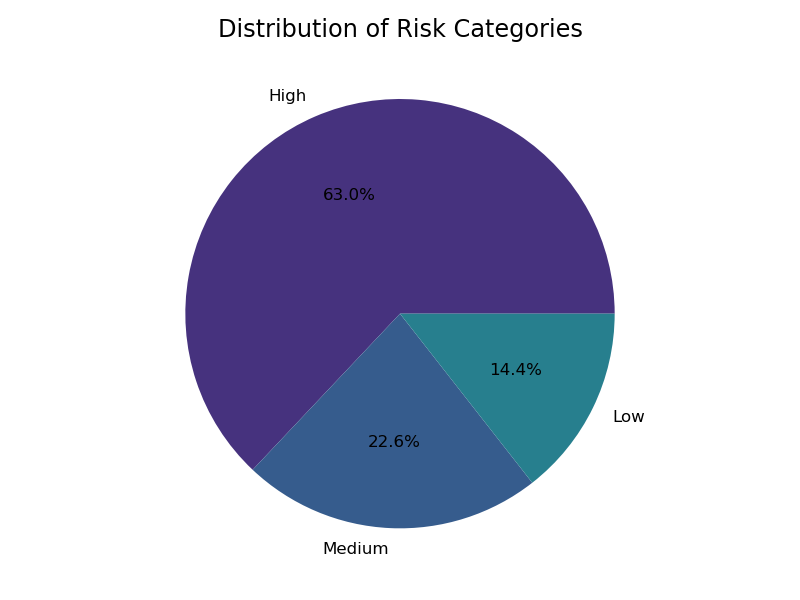

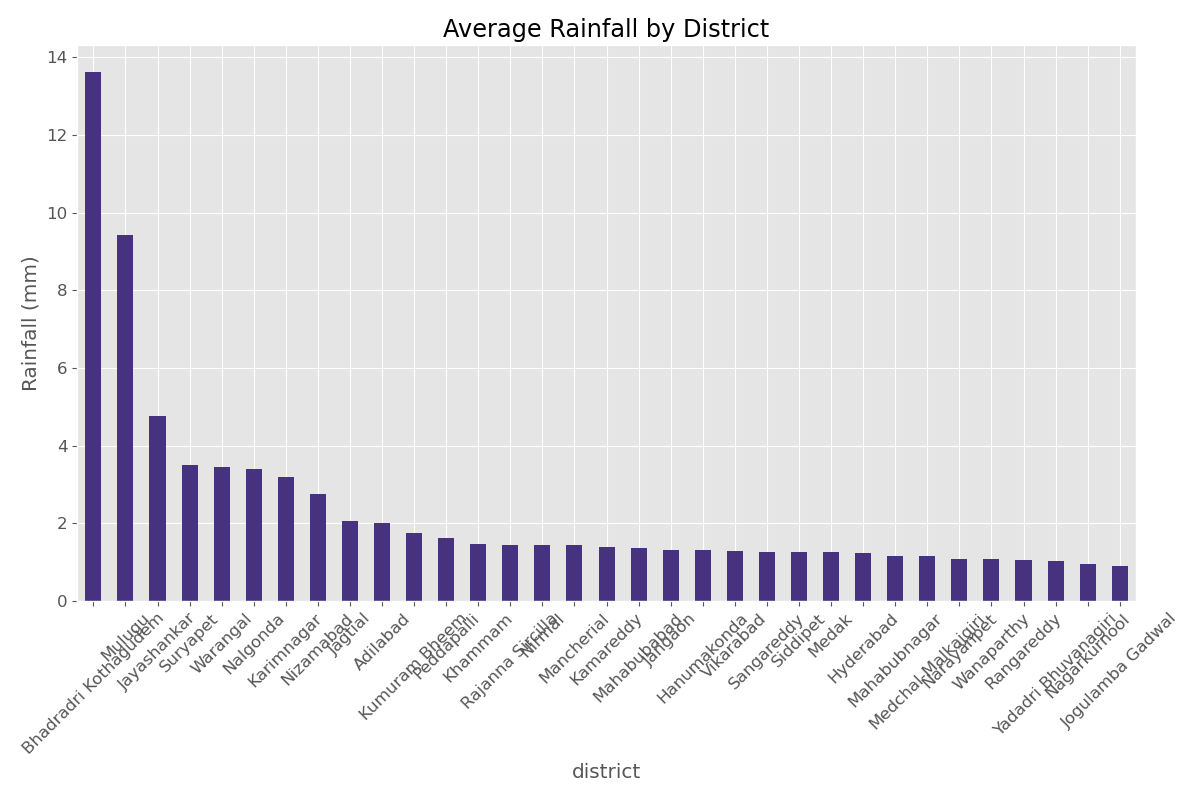

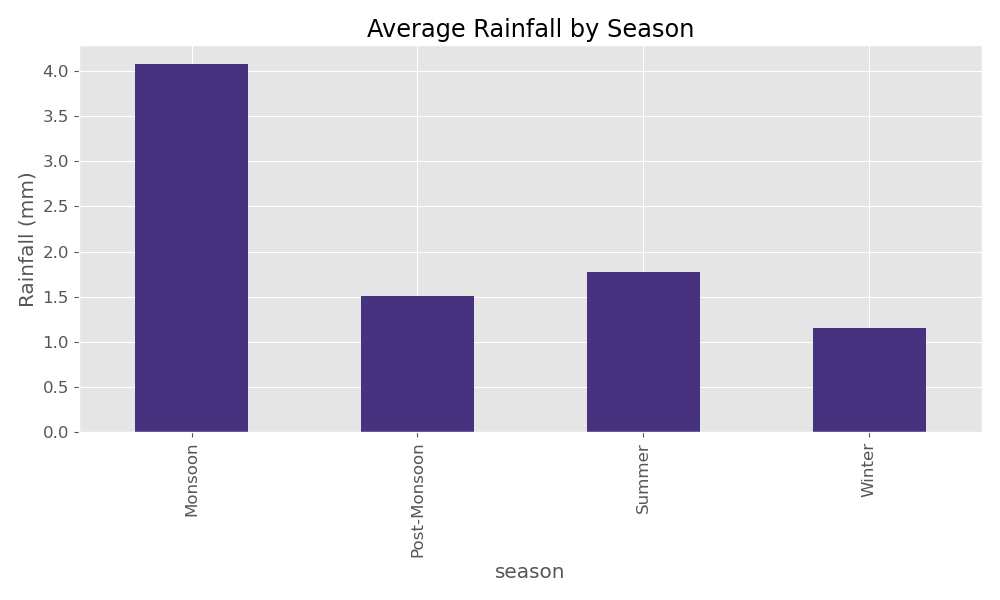

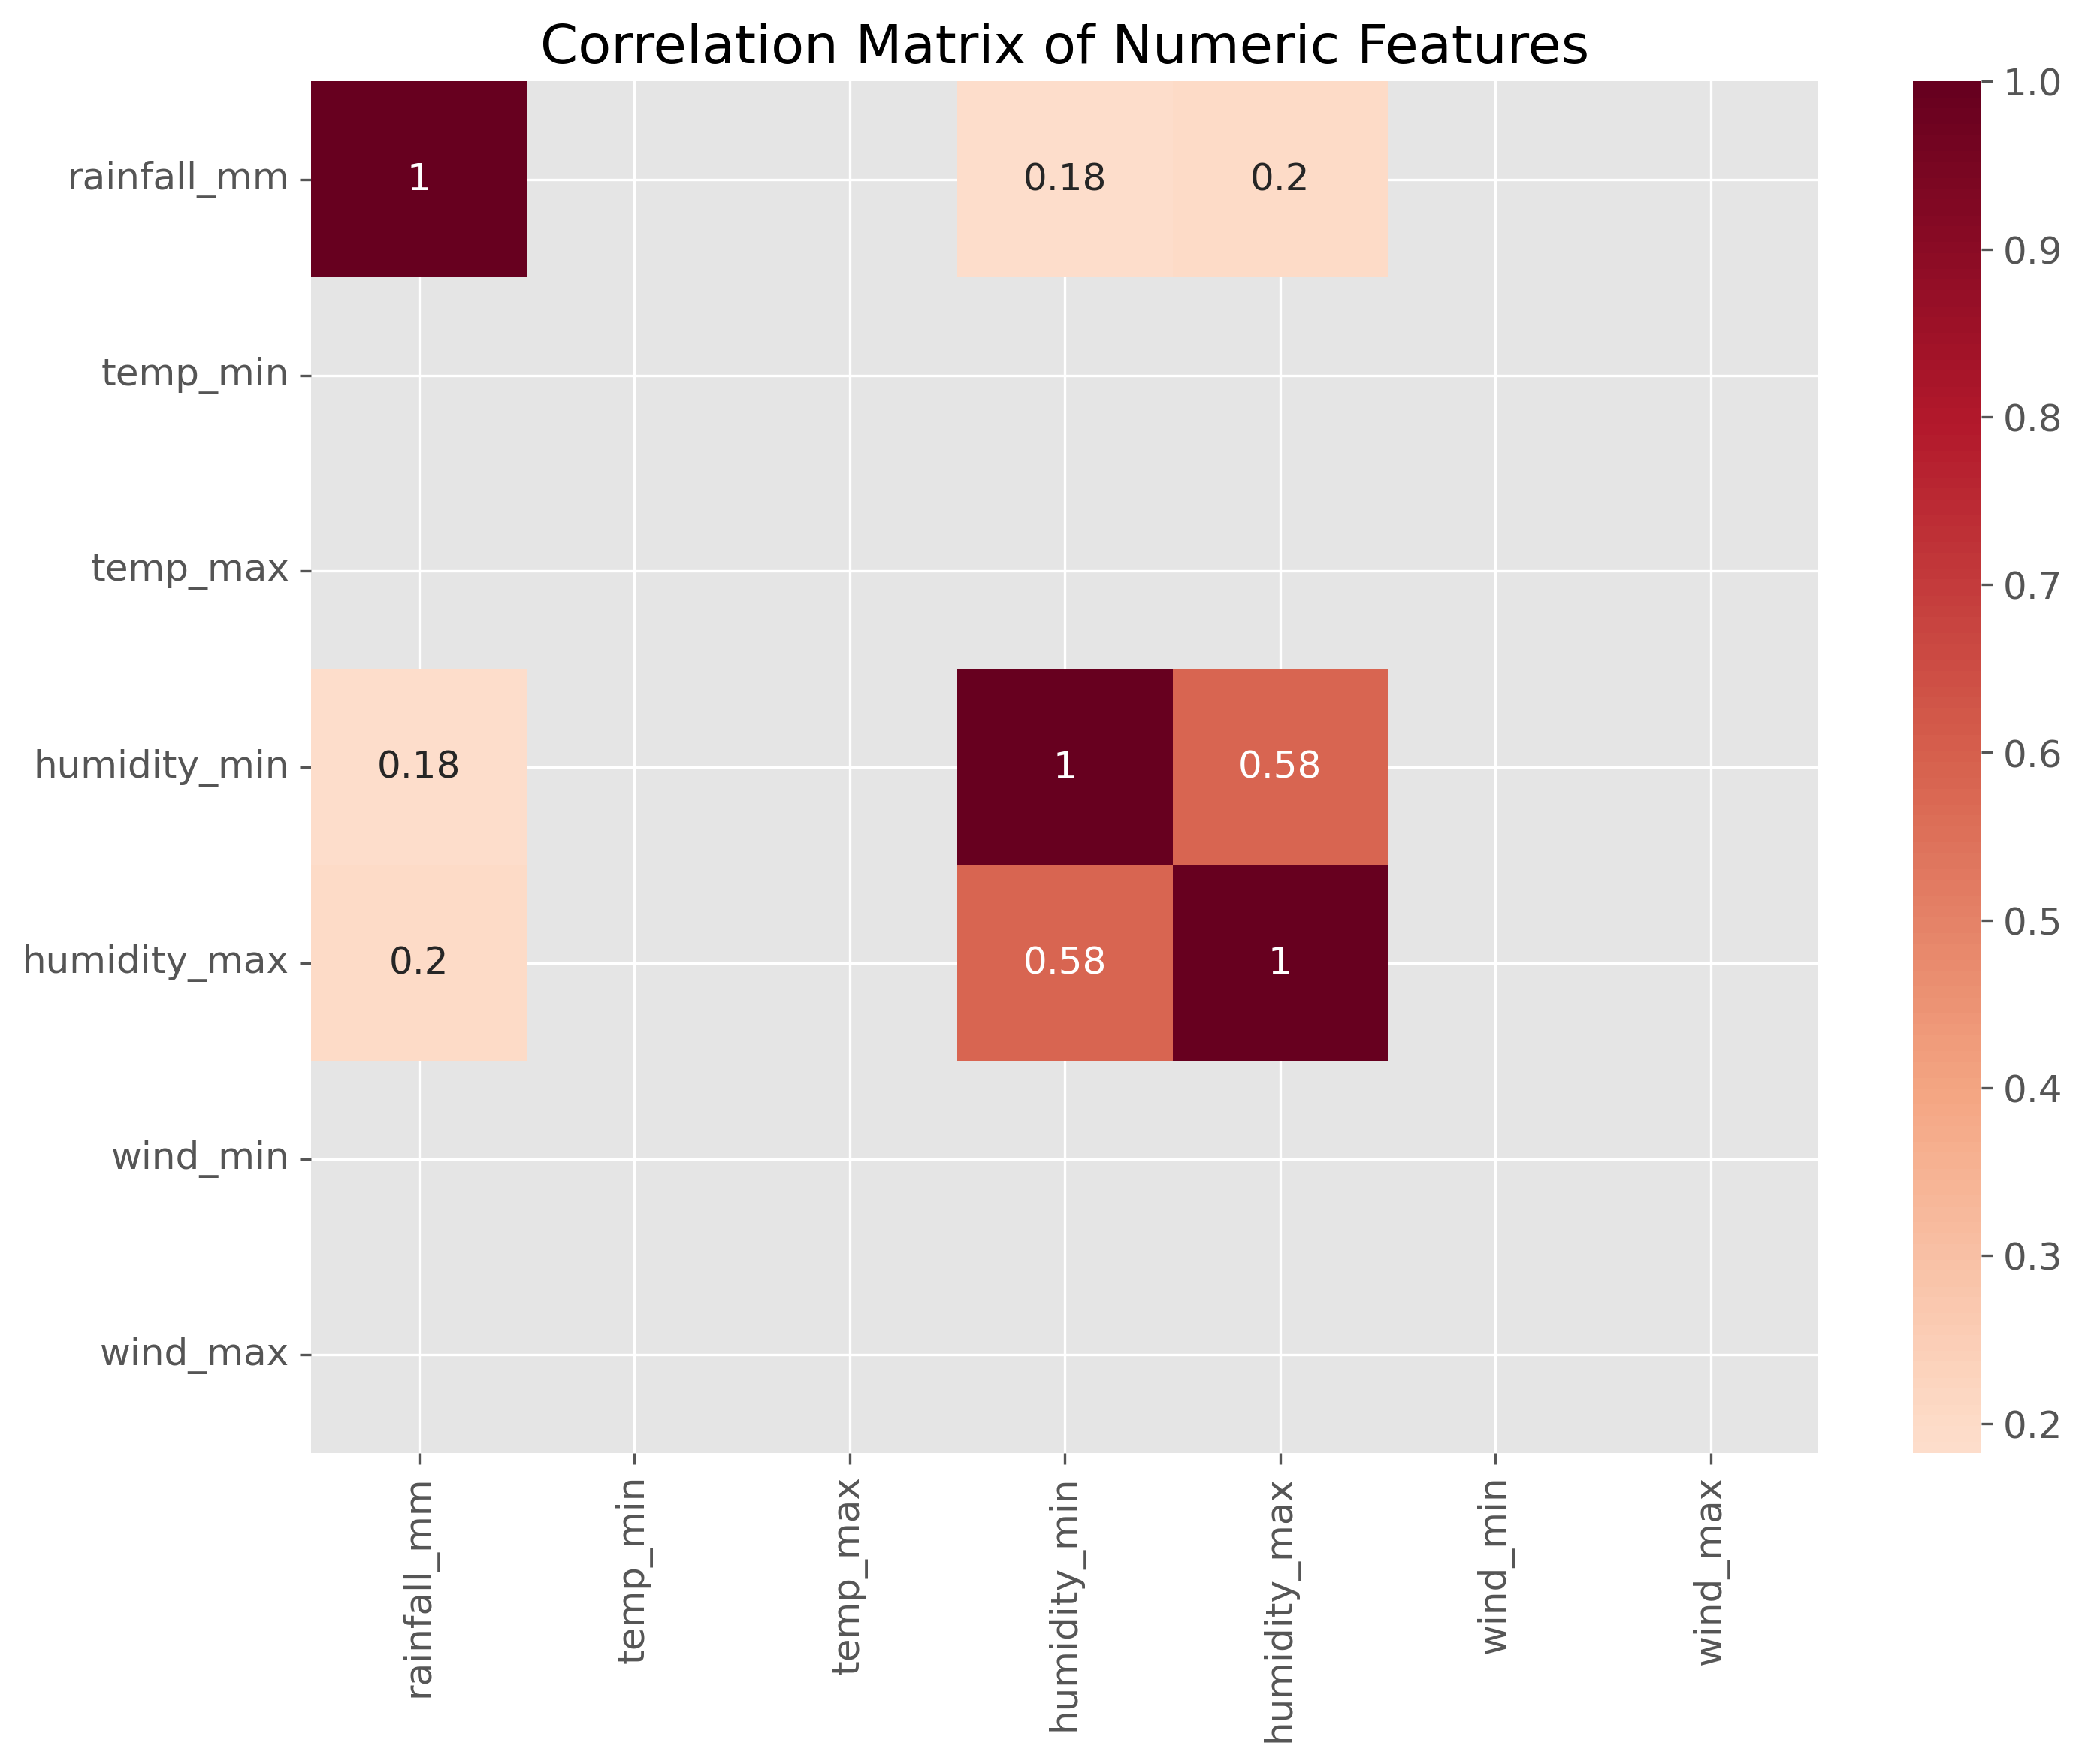

<Figure size 1200x800 with 0 Axes>

In [9]:
# Cell 9: Run the complete pipeline

df_clean, insights, cli = run_rtgs_pipeline()


print("\n" + "=" * 60)
print("DISPLAYING KEY VISUALIZATIONS")
print("=" * 60)


risk_img_path = f"{Config.OUTPUT_DIR}/visualizations/risk_distribution.png"
if os.path.exists(risk_img_path):
    display(HTML("<h3>Risk Category Distribution</h3>"))
    display(Image(filename=risk_img_path))


rainfall_img_path = f"{Config.OUTPUT_DIR}/visualizations/district_rainfall.png"
if os.path.exists(rainfall_img_path):
    display(HTML("<h3>Average Rainfall by District</h3>"))
    display(Image(filename=rainfall_img_path))


seasonal_img_path = f"{Config.OUTPUT_DIR}/visualizations/seasonal_rainfall.png"
if os.path.exists(seasonal_img_path):
    display(HTML("<h3>Average Rainfall by Season</h3>"))
    display(Image(filename=seasonal_img_path))


corr_img_path = f"{Config.OUTPUT_DIR}/visualizations/correlation_matrix.png"
if os.path.exists(corr_img_path):
    display(HTML("<h3>Correlation Matrix</h3>"))
    display(Image(filename=corr_img_path))


In [10]:
# Cell 10: Enhanced Professional Dashboard with Multi-Language Support
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Javascript
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import random
from datetime import datetime
import pandas as pd
import numpy as np

class EnhancedRTGSDashboard:
    """Enhanced professional dashboard with multi-language support"""
    
    def __init__(self, df, insights):
        self.df = df
        self.insights = insights
        self.current_language = "English"
        
        
        self.language_packs = {
            "English": {
                "dashboard_title": "Telangana Climate Risk Dashboard",
                "dashboard_subtitle": "Comprehensive analysis of climate risks and adaptation strategies",
                "overview_tab": "Overview",
                "district_tab": "District Analysis",
                "risk_tab": "Risk Assessment", 
                "recommendations_tab": "Recommendations",
                "chat_tab": "Chat with Data",
                "select_district": "Select District:",
                "select_analysis": "Analysis Type:",
                "select_year": "Year:",
                "risk_factors": "Risk Factors",
                "rainfall_patterns": "Rainfall Patterns",
                "temperature_trends": "Temperature Trends",
                "vulnerability_index": "Vulnerability Index",
                "quick_stats": "Quick Stats",
                "total_districts": "Total Districts",
                "avg_temperature": "Avg. Temperature",
                "avg_rainfall": "Avg. Rainfall",
                "avg_wind_speed": "Avg. Wind Speed",
                "risk_assessment": "Risk Assessment",
                "low_risk": "Low Risk (0-4)",
                "medium_risk": "Medium Risk (5-7)", 
                "high_risk": "High Risk (8-10)",
                "action_recommendations": "Action Recommendations",
                "timeframe": "Timeframe:",
                "risk_type": "Risk Type:",
                "all": "All",
                "short_term": "Short-term",
                "medium_term": "Medium-term", 
                "long_term": "Long-term",
                "drought": "Drought",
                "flood": "Flood",
                "heatwave": "Heatwave",
                "agriculture": "Agriculture",
                "water": "Water",
                "chat_placeholder": "Ask a question about climate data...",
                "send": "Send",
                "suggestions": "Try asking:",
                "recommendation_engine": "Recommendation Engine",
                "tip": "Tip: Use the filters to narrow down recommendations",
                "email_recommendations": "Email Recommendations",
                "generate_action_plan": "Generate Action Plan",
                "export_pdf": "Export to PDF",
                "climate_assistant": "Climate Assistant",
                "typing": "Typing...",
                "hello": "Hello! I'm your Climate Data Assistant.",
                "assist": "How can I assist you today?",
                "risk_distribution": "Risk Distribution",
                "risk_map": "Risk Map Visualization",
                "for": "for",
                "recommendations": "Recommendations",
                "district_comparison": "District Comparison",
                "trend_analysis": "Trend Analysis",
                "data_export": "Data Export",
                "settings": "Settings"
            },
            "Telugu": {
                "dashboard_title": "తెలంగాణ వాతావరణ ప్రమాద డాష్బోర్డ్",
                "dashboard_subtitle": "వాతావరణ ప్రమాదాలు మరియు అనుకూలీకరణ వ్యూహాల సమగ్ర విశ్లేషణ",
                "overview_tab": "అవలోకనం",
                "district_tab": "జిల్లా విశ్లేషణ",
                "risk_tab": "రిస్క్ అంచనా", 
                "recommendations_tab": "సిఫార్సులు",
                "chat_tab": "డేటాతో చాట్ చేయండి",
                "select_district": "జిల్లా ఎంచుకోండి:",
                "select_analysis": "విశ్లేషణ రకం:",
                "select_year": "సంవత్సరం:",
                "risk_factors": "రిస్క్ కారకాలు",
                "rainfall_patterns": "వర్షపాతం నమూనాలు",
                "temperature_trends": "ఉష్ణోగ్రత ధోరణులు",
                "vulnerability_index": "అసురక్షిత సూచిక",
                "quick_stats": "శీఘ్ర గణాంకాలు",
                "total_districts": "మొత్తం జిల్లాలు",
                "avg_temperature": "సగటు ఉష్ణోగ్రత",
                "avg_rainfall": "సగటు వర్షపాతం",
                "avg_wind_speed": "సగటు గాలి వేగం",
                "risk_assessment": "రిస్క్ అంచనా",
                "low_risk": "తక్కువ రిస్క్ (0-4)",
                "medium_risk": "మధ్యస్థ రిస్క్ (5-7)", 
                "high_risk": "అధిక రిస్క్ (8-10)",
                "action_recommendations": "చర్య సిఫార్సులు",
                "timeframe": "సమయపరిమితి:",
                "risk_type": "రిస్క్ రకం:",
                "all": "అన్నీ",
                "short_term": "స్వల్పకాలిక",
                "medium_term": "మధ్యకాలిక", 
                "long_term": "దీర్ఘకాలిక",
                "drought": "బరువు",
                "flood": "వరద",
                "heatwave": "వేడి అల",
                "agriculture": "వ్యవసాయం",
                "water": "నీరు",
                "chat_placeholder": "వాతావరణ డేటా గురించి ప్రశ్నించండి...",
                "send": "పంపించు",
                "suggestions": "ఇలా ప్రశ్నించండి:",
                "recommendation_engine": "సిఫార్సు ఇంజిన్",
                "tip": "చిట్కా: మీ ప్రాధాన్యతల ఆధారంగా సిఫార్సులను శుద్ధీకరించడానికి ఫిల్టర్లను ఉపయోగించండి",
                "email_recommendations": "సిఫార్సులను ఇమెయిల్ చేయండి",
                "generate_action_plan": "చర్య ప్రణాళికను రూపొందించండి",
                "export_pdf": "PDFగా ఎగుమతి చేయండి",
                "climate_assistant": "వాతావరణ సహాయక",
                "typing": "టైప్ చేస్తోంది...",
                "hello": "నమస్కారం! నేను మీ వాతావరణ డేటా సహాయకుడిని.",
                "assist": "ఈరోజు నేను మీకు ఎలా సహాయపడగలను?",
                "risk_distribution": "రిస్క్ పంపిణీ",
                "risk_map": "రిస్క్ మ్యాప్ విజువలైజేషన్",
                "for": "కోసం",
                "recommendations": "సిఫార్సులు",
                "district_comparison": "జిల్లా పోలిక",
                "trend_analysis": "ట్రెండ్ విశ్లేషణ",
                "data_export": "డేటా ఎగుమతి",
                "settings": "సెట్టింగ్స్"
            },
            "Hindi": {
                "dashboard_title": "तेलंगाना जलवायु जोखिम डैशबोर्ड",
                "dashboard_subtitle": "जलवायु जोखिमों और अनुकूलन रणनीतियों का व्यापक विश्लेषण",
                "overview_tab": "अवलोकन",
                "district_tab": "जिला विश्लेषण",
                "risk_tab": "जोखिम आकलन", 
                "recommendations_tab": "सिफारिशें",
                "chat_tab": "डेटा के साथ चैट करें",
                "select_district": "जिला चुनें:",
                "select_analysis": "विश्लेषण प्रकार:",
                "select_year": "वर्ष:",
                "risk_factors": "जोखिम कारक",
                "rainfall_patterns": "वर्षा पैटर्न",
                "temperature_trends": "तापमान रुझान",
                "vulnerability_index": "भेद्यता सूचकांक",
                "quick_stats": "त्वरित आँकड़े",
                "total_districts": "कुल जिले",
                "avg_temperature": "औसत तापमान",
                "avg_rainfall": "औसत वर्षा",
                "avg_wind_speed": "औसत हवा की गति",
                "risk_assessment": "जोखिम आकलन",
                "low_risk": "कम जोखिम (0-4)",
                "medium_risk": "मध्यम जोखिम (5-7)", 
                "high_risk": "उच्च जोखिम (8-10)",
                "action_recommendations": "कार्रवाई सिफारिशें",
                "timeframe": "समयसीमा:",
                "risk_type": "जोखिम प्रकार:",
                "all": "सभी",
                "short_term": "अल्पकालिक",
                "medium_term": "मध्यम अवधि", 
                "long_term": "दीर्घकालिक",
                "drought": "सूखा",
                "flood": "बाढ़",
                "heatwave": "लू",
                "agriculture": "कृषि",
                "water": "पानी",
                "chat_placeholder": "जलवायु डेटा के बारे में प्रश्न पूछें...",
                "send": "भेजें",
                "suggestions": "इस तरह पूछें:",
                "recommendation_engine": "सिफारिश इंजन",
                "tip": "टिप: अपनी प्राथमिकताओं के आधार पर सिफारिशों को निर्दिष्ट करने के लिए फ़िल्टर का उपयोग करें",
                "email_recommendations": "सिफारिशें ईमेल करें",
                "generate_action_plan": "कार्य योजना बनाएं",
                "export_pdf": "PDF निर्यात करें",
                "climate_assistant": "जलवायु सहायक",
                "typing": "टाइप कर रहा है...",
                "hello": "नमस्ते! मैं आपका जलवायु डेटा सहायक हूं।",
                "assist": "आज मैं आपकी कैसे सहायता कर सकता हूं?",
                "risk_distribution": "जोखिम वितरण",
                "risk_map": "जोखिम मानचित्र दृश्य",
                "for": "के लिए",
                "recommendations": "सिफारिशें",
                "district_comparison": "जिला तुलना",
                "trend_analysis": "ट्रेंड विश्लेषण",
                "data_export": "डेटा निर्यात",
                "settings": "सेटिंग्स"
            }
        }
        
        
        self.setup_dashboard()
    
    def t(self, key):
        """Translate a key to the current language"""
        return self.language_packs[self.current_language].get(key, key)
    
    def setup_dashboard(self):
        """Setup the complete dashboard with all components"""
        
        css_styles = """
        <style>
            .dashboard-container {
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                color: #333;
                margin: 0;
                padding: 0;
            }
            .dashboard-header {
                background: linear-gradient(135deg, #1a2a6c, #b21f1f, #fdbb2d);
                color: white;
                padding: 20px;
                border-radius: 10px;
                margin-bottom: 20px;
                text-align: center;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            }
            .metric-card {
                background: white;
                padding: 15px;
                border-radius: 10px;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1);
                text-align: center;
                transition: transform 0.3s ease;
                margin: 10px;
            }
            .metric-card:hover {
                transform: translateY(-5px);
                box-shadow: 0 6px 12px rgba(0,0,0,0.15);
            }
            .tab-content {
                padding: 20px;
                background: #f8f9fa;
                border-radius: 0 0 10px 10px;
            }
            .chat-container {
                height: 400px;
                overflow-y: auto;
                background: white;
                border-radius: 10px;
                padding: 15px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            }
            .user-message {
                background: #e3f2fd;
                padding: 10px 15px;
                border-radius: 18px 18px 0 18px;
                margin: 10px 0;
                max-width: 80%;
                margin-left: auto;
            }
            .bot-message {
                background: #f5f5f5;
                padding: 10px 15px;
                border-radius: 18px 18px 18px 0;
                margin: 10px 0;
                max-width: 80%;
            }
            .risk-low {
                color: #28a745;
                font-weight: bold;
            }
            .risk-medium {
                color: #ffc107;
                font-weight: bold;
            }
            .risk-high {
                color: #dc3545;
                font-weight: bold;
            }
            .suggestion-chip {
                display: inline-block;
                background: #e9ecef;
                padding: 5px 10px;
                border-radius: 20px;
                margin: 5px;
                cursor: pointer;
                transition: background 0.3s;
                font-size: 12px;
            }
            .suggestion-chip:hover {
                background: #dee2e6;
            }
            .widget-label {
                font-weight: bold;
                margin-bottom: 5px;
            }
            .tab-button {
                border-radius: 8px 8px 0 0 !important;
            }
            .filter-panel {
                background: white;
                padding: 15px;
                border-radius: 10px;
                box-shadow: 0 2px 8px rgba(0,0,0,0.1);
                margin-bottom: 15px;
            }
            .loading-indicator {
                display: inline-block;
                width: 20px;
                height: 20px;
                border: 3px solid rgba(255,255,255,.3);
                border-radius: 50%;
                border-top-color: #fff;
                animation: spin 1s ease-in-out infinite;
            }
            @keyframes spin {
                to { transform: rotate(360deg); }
            }
            .map-container {
                height: 500px;
                border-radius: 10px;
                overflow: hidden;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            }
            .smooth-transition {
                transition: all 0.3s ease;
            }
            .action-button {
                background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
                color: white;
                border: none;
                padding: 10px 20px;
                border-radius: 5px;
                cursor: pointer;
                transition: all 0.3s ease;
                margin: 5px;
            }
            .action-button:hover {
                transform: translateY(-2px);
                box-shadow: 0 4px 8px rgba(0,0,0,0.2);
            }
            .sidebar {
                background: white;
                padding: 15px;
                border-radius: 10px;
                box-shadow: 0 2px 8px rgba(0,0,0,0.1);
                height: fit-content;
            }
        </style>
        """
        
       
        display(HTML(css_styles))
        
        
        main_container = widgets.VBox(layout=widgets.Layout(width='100%', padding='10px'))
        
        
        header_html = f"""
        <div class="dashboard-header">
            <h1>🌍 {self.t('dashboard_title')}</h1>
            <p>{self.t('dashboard_subtitle')}</p>
        </div>
        """
        header = widgets.HTML(value=header_html)
        
        # Create tabs for different sections
        tab_titles = [self.t('overview_tab'), self.t('district_tab'), self.t('risk_tab'), 
                     self.t('recommendations_tab'), self.t('chat_tab')]
        tabs = widgets.Tab(children=[widgets.Output() for _ in tab_titles])
        for i, title in enumerate(tab_titles):
            tabs.set_title(i, title)
        
        # Define content for each tab
        with tabs.children[0]:
            clear_output()
            self.create_overview_tab()
        
        with tabs.children[1]:
            clear_output()
            self.create_district_analysis_tab()
        
        with tabs.children[2]:
            clear_output()
            self.create_risk_assessment_tab()
        
        with tabs.children[3]:
            clear_output()
            self.create_recommendations_tab()
        
        with tabs.children[4]:
            clear_output()
            self.create_chat_tab()
        
        # Language selector
        language_selector = widgets.Dropdown(
            options=['English', 'Telugu', 'Hindi'],
            value=self.current_language,
            description='Language:',
            disabled=False,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px', margin='10px 0')
        )
        
        def update_language(change):
            self.current_language = change['new']
            # Refresh all tabs
            with tabs.children[0]:
                clear_output()
                self.create_overview_tab()
            with tabs.children[1]:
                clear_output()
                self.create_district_analysis_tab()
            with tabs.children[2]:
                clear_output()
                self.create_risk_assessment_tab()
            with tabs.children[3]:
                clear_output()
                self.create_recommendations_tab()
            with tabs.children[4]:
                clear_output()
                self.create_chat_tab()
            
            # Update header
            header_html = f"""
            <div class="dashboard-header">
                <h1>🌍 {self.t('dashboard_title')}</h1>
                <p>{self.t('dashboard_subtitle')}</p>
            </div>
            """
            header.value = header_html
        
        language_selector.observe(update_language, names='value')
        
        
        main_container.children = [header, language_selector, tabs]
        
      
        display(main_container)
    
    def create_overview_tab(self):
        """Create the overview tab content"""
        display(HTML(f"<h2 style='color:#1f77b4; text-align:center;'>{self.t('overview_tab')}</h2>"))
        display(HTML(f"<p style='text-align:center;'>{self.t('dashboard_subtitle')}</p>"))
        
        
        total_districts = self.df['district'].nunique() if 'district' in self.df.columns else 0
        avg_temp = self.df['avg_temp'].mean() if 'avg_temp' in self.df.columns else 0
        avg_rainfall = self.df['rainfall_mm'].mean() if 'rainfall_mm' in self.df.columns else 0
        avg_wind_speed = self.df['wind_speed'].mean() if 'wind_speed' in self.df.columns else 0
        
        metrics_html = f"""
        <div style='display: flex; justify-content: space-around; margin: 20px 0; flex-wrap: wrap;'>
            <div class="metric-card" style='background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%); color: white; width: 22%;'>
                <h3>{total_districts}</h3>
                <p>{self.t('total_districts')}</p>
            </div>
            <div class="metric-card" style='background: linear-gradient(135deg, #FF512F 0%, #F09819 100%); color: white; width: 22%;'>
                <h3>{avg_wind_speed:.1f} km/h</h3>
                <p>{self.t('avg_wind_speed')}</p>
            </div>
            <div class="metric-card" style='background: linear-gradient(135deg, #0ba360 0%, #3cba92 100%); color: white; width: 22%;'>
                <h3>{avg_rainfall:.1f} mm</h3>
                <p>{self.t('avg_rainfall')}</p>
            </div>
            <div class="metric-card" style='background: linear-gradient(135deg, #C471F5 0%, #FA71CD 100%); color: white; width: 22%;'>
                <h3>{avg_temp:.1f}°C</h3>
                <p>{self.t('avg_temperature')}</p>
            </div>
        </div>
        """
        display(HTML(metrics_html))
        
       
        col1, col2 = widgets.Output(), widgets.Output()
        
        with col1:
            
            if 'risk_category' in self.df.columns:
                risk_counts = self.df['risk_category'].value_counts()
                fig = px.pie(values=risk_counts.values, names=risk_counts.index, 
                            title=self.t('risk_distribution'))
                fig.update_traces(textposition='inside', textinfo='percent+label')
                fig.show()
        
        with col2:
            
            if 'district' in self.df.columns and 'ari_normalized' in self.df.columns:
                district_risk = self.df.groupby('district')['ari_normalized'].mean().reset_index()
                district_risk = district_risk.sort_values('ari_normalized', ascending=False).head(10)
                
                fig = px.bar(district_risk, x='district', y='ari_normalized', 
                            title='Top 10 Districts by Risk Index',
                            color='ari_normalized',
                            color_continuous_scale='RdYlGn_r')
                fig.update_layout(xaxis_title='District', yaxis_title='Risk Index')
                fig.show()
        
       
        display(widgets.HBox([col1, col2]))
        
        
        display(HTML("<h3 style='color:#1f77b4; text-align:center; margin-top:30px;'>Climate Trends Over Time</h3>"))
        
        trend_output = widgets.Output()
        with trend_output:
            if 'year' in self.df.columns:
                # Create a line chart showing trends over time
                yearly_data = self.df.groupby('year').agg({
                    'rainfall_mm': 'mean',
                    'avg_temp': 'mean',
                    'ari_normalized': 'mean'
                }).reset_index()
                
                fig = make_subplots(specs=[[{"secondary_y": True}]])
                

                fig.add_trace(
                    go.Scatter(x=yearly_data['year'], y=yearly_data['rainfall_mm'], name="Rainfall (mm)", line=dict(color='blue')),
                    secondary_y=False,
                )
                
                
                fig.add_trace(
                    go.Scatter(x=yearly_data['year'], y=yearly_data['avg_temp'], name="Temperature (°C)", line=dict(color='red')),
                    secondary_y=True,
                )
                
                
                fig.add_trace(
                    go.Scatter(x=yearly_data['year'], y=yearly_data['ari_normalized'], name="Risk Index", line=dict(color='green')),
                    secondary_y=False,
                )
                
                
                fig.update_xaxes(title_text="Year")
                
                
                fig.update_yaxes(title_text="Rainfall (mm) / Risk Index", secondary_y=False)
                fig.update_yaxes(title_text="Temperature (°C)", secondary_y=True)
                
                fig.update_layout(title_text="Climate Trends Over Time")
                fig.show()
        
        display(trend_output)
    
    def create_district_analysis_tab(self):
        """Create the district analysis tab content"""
        display(HTML(f"<h2 style='color:#1f77b4; text-align:center;'>{self.t('district_tab')}</h2>"))
        
        
        left_panel = widgets.VBox(layout=widgets.Layout(width='30%', padding='10px'))
        right_panel = widgets.Output(layout=widgets.Layout(width='70%'))
        
        
        district_options = ['All'] + sorted(self.df['district'].unique().tolist()) if 'district' in self.df.columns else ['All']
        district_selector = widgets.Dropdown(
            options=district_options,
            value='All',
            description=self.t('select_district'),
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        
        
        analysis_options = [self.t('risk_factors'), self.t('rainfall_patterns'), 
                           self.t('temperature_trends'), self.t('vulnerability_index')]
        analysis_selector = widgets.Dropdown(
            options=analysis_options,
            value=self.t('risk_factors'),
            description=self.t('select_analysis'),
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        
        
        year_options = ['All'] + sorted(self.df['year'].unique().tolist()) if 'year' in self.df.columns else ['All']
        year_selector = widgets.Dropdown(
            options=year_options,
            value='All',
            description=self.t('select_year'),
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        
        
        total_districts = self.df['district'].nunique() if 'district' in self.df.columns else 0
        avg_temp = self.df['avg_temp'].mean() if 'avg_temp' in self.df.columns else 0
        avg_rainfall = self.df['rainfall_mm'].mean() if 'rainfall_mm' in self.df.columns else 0
        
        stats_html = f"""
        <div class="metric-card">
            <h4>{self.t('quick_stats')}</h4>
            <p>📊 {self.t('total_districts')}: {total_districts}</p>
            <p>🌡️ {self.t('avg_temperature')}: {avg_temp:.1f}°C</p>
            <p>🌧️ {self.t('avg_rainfall')}: {avg_rainfall:.1f} mm</p>
        </div>
        """
        stats_widget = widgets.HTML(value=stats_html)
        
        
        compare_button = widgets.Button(
            description=self.t('district_comparison'),
            button_style='info',
            tooltip='Compare selected district with others',
            layout=widgets.Layout(width='90%', margin='10px 0')
        )
        
        
        left_panel.children = [district_selector, analysis_selector, year_selector, stats_widget, compare_button]
        
       
        def update_analysis(change):
            with right_panel:
                clear_output()
                district = district_selector.value
                analysis_type = analysis_selector.value
                year = year_selector.value
                
                display(HTML(f"<h3 style='color:#1f77b4;'>{analysis_type} {self.t('for')} {district if district != 'All' else 'All Districts'} ({year if year != 'All' else 'All Years'})</h3>"))
                
                # Filter data based on selections
                filtered_df = self.df.copy()
                
                if district != 'All':
                    filtered_df = filtered_df[filtered_df['district'] == district]
                
                if year != 'All':
                    filtered_df = filtered_df[filtered_df['year'] == year]
                
                # Generate appropriate visualization based on analysis type
                if analysis_type == self.t('risk_factors'):
                    self.create_risk_factors_visualization(filtered_df, district)
                elif analysis_type == self.t('rainfall_patterns'):
                    self.create_rainfall_visualization(filtered_df, district)
                elif analysis_type == self.t('temperature_trends'):
                    self.create_temperature_visualization(filtered_df, district)
                elif analysis_type == self.t('vulnerability_index'):
                    self.create_vulnerability_visualization(filtered_df, district)
        
        def show_comparison(b):
            with right_panel:
                clear_output()
                district = district_selector.value
                if district == 'All':
                    display(HTML("<p style='color:red;'>Please select a specific district to compare.</p>"))
                    return
                
                display(HTML(f"<h3 style='color:#1f77b4;'>{self.t('district_comparison')}: {district} vs. Other Districts</h3>"))
                
                # Create comparison visualizations
                if 'ari_normalized' in self.df.columns:
                    
                    district_risk = self.df[self.df['district'] == district]['ari_normalized'].mean()
                    
                    
                    other_risk = self.df[self.df['district'] != district]['ari_normalized'].mean()
                    
                  
                    fig = px.bar(x=[district, 'Other Districts'], y=[district_risk, other_risk],
                                labels={'x': 'District', 'y': 'Risk Index'},
                                title=f'Risk Comparison: {district} vs. Other Districts',
                                color=[district, 'Other Districts'],
                                color_discrete_map={district: '#FF6B6B', 'Other Districts': '#4ECDC4'})
                    fig.show()
        
        
        district_selector.observe(update_analysis, names='value')
        analysis_selector.observe(update_analysis, names='value')
        year_selector.observe(update_analysis, names='value')
        compare_button.on_click(show_comparison)
        
        
        display(widgets.HBox([left_panel, right_panel]))
        update_analysis(None)  # Initial update
    
    def create_risk_factors_visualization(self, filtered_df, district):
        """Create risk factors visualization"""
        if 'risk_category' in filtered_df.columns:
            risk_counts = filtered_df['risk_category'].value_counts()
            fig = px.pie(values=risk_counts.values, names=risk_counts.index, 
                        title=f'Risk Distribution for {district if district != "All" else "All Districts"}')
            fig.update_traces(textposition='inside', textinfo='percent+label')
            fig.show()
        
        
        risk_html = f"""
        <div style='margin-top: 20px;'>
            <h4>{self.t('risk_assessment')}</h4>
            <p><span class="risk-low">{self.t('low_risk')}</span>: Minimal immediate action needed</p>
            <p><span class="risk-medium">{self.t('medium_risk')}</span>: Monitoring and planning recommended</p>
            <p><span class="risk-high">{self.t('high_risk')}</span>: Immediate action required</p>
        </div>
        """
        display(HTML(risk_html))
    
    def create_rainfall_visualization(self, filtered_df, district):
        """Create rainfall visualization"""
        if 'month' in filtered_df.columns and 'rainfall_mm' in filtered_df.columns:
            monthly_rain = filtered_df.groupby('month')['rainfall_mm'].mean()
            fig = px.bar(x=monthly_rain.index, y=monthly_rain.values, 
                        labels={'x': 'Month', 'y': 'Rainfall (mm)'},
                        title=f'Average Monthly Rainfall for {district if district != "All" else "All Districts"}',
                        color=monthly_rain.values,
                        color_continuous_scale='Blues')
            fig.show()
        
        if 'rainfall_mm' in filtered_df.columns:
            display(HTML(f"""
            <div style='margin-top: 20px;'>
                <h4>Rainfall Statistics</h4>
                <p>📊 Average Rainfall: <b>{filtered_df['rainfall_mm'].mean():.1f} mm</b></p>
                <p>📈 Maximum Rainfall: <b>{filtered_df['rainfall_mm'].max():.1f} mm</b></p>
                <p>📉 Minimum Rainfall: <b>{filtered_df['rainfall_mm'].min():.1f} mm</b></p>
            </div>
            """))
    
    def create_temperature_visualization(self, filtered_df, district):
        """Create temperature visualization"""
        if 'avg_temp' in filtered_df.columns:
            fig = px.histogram(filtered_df, x='avg_temp', 
                             title=f'Temperature Distribution for {district if district != "All" else "All Districts"}',
                             labels={'avg_temp': 'Temperature (°C)'},
                             color_discrete_sequence=['#FF6B6B'])
            fig.show()
        
        if 'avg_temp' in filtered_df.columns:
            display(HTML(f"""
            <div style='margin-top: 20px;'>
                <h4>Temperature Statistics</h4>
                <p>📊 Average Temperature: <b>{filtered_df['avg_temp'].mean():.1f}°C</b></p>
                <p>📈 Maximum Temperature: <b>{filtered_df['avg_temp'].max():.1f}°C</b></p>
                <p>📉 Minimum Temperature: <b>{filtered_df['avg_temp'].min():.1f}°C</b></p>
            </div>
            """))
    
    def create_vulnerability_visualization(self, filtered_df, district):
        """Create vulnerability visualization"""
        if 'ari_normalized' in filtered_df.columns:
            fig = px.box(filtered_df, y='ari_normalized', 
                       title=f'Risk Index Distribution for {district if district != "All" else "All Districts"}',
                       labels={'ari_normalized': 'Risk Index'},
                       color_discrete_sequence=['#4ECDC4'])
            fig.show()
        
        if 'ari_normalized' in filtered_df.columns:
            display(HTML(f"""
            <div style='margin-top: 20px;'>
                <h4>Risk Index Statistics</h4>
                <p>📊 Average Risk Index: <b>{filtered_df['ari_normalized'].mean():.1f}</b></p>
                <p>📈 Maximum Risk Index: <b>{filtered_df['ari_normalized'].max():.1f}</b></p>
                <p>📉 Minimum Risk Index: <b>{filtered_df['ari_normalized'].min():.1f}</b></p>
            </div>
            """))
    
    def create_risk_assessment_tab(self):
        """Create the risk assessment tab content"""
        display(HTML(f"<h2 style='color:#1f77b4; text-align:center;'>{self.t('risk_tab')}</h2>"))
        
        # Create risk visualization
        if 'district' in self.df.columns and 'ari_normalized' in self.df.columns:
            district_risk = self.df.groupby('district')['ari_normalized'].mean().reset_index()
            
            # Create a bubble chart
            fig = px.scatter(
                district_risk, 
                x='district', 
                y='ari_normalized',
                size='ari_normalized',
                color='ari_normalized',
                color_continuous_scale='RdYlGn_r',
                title='Climate Risk by District',
                labels={'ari_normalized': 'Risk Index', 'district': 'District'}
            )
            fig.update_layout(xaxis_tickangle=-45)
            fig.show()
        
        # Create an interactive risk map
        display(HTML(f"<h3 style='color:#1f77b4; text-align:center;'>{self.t('risk_map')}</h3>"))
        
        # Create a map visualization using Plotly
        map_output = widgets.Output()
        with map_output:
            # Create sample coordinates for Telangana districts (in a real scenario, use actual coordinates)
            district_coords = {
                'Adilabad': (19.6667, 78.5333),
                'Hyderabad': (17.3850, 78.4867),
                'Karimnagar': (18.4333, 79.1500),
                'Khammam': (17.2473, 80.1514),
                'Mahabubnagar': (16.7333, 77.9833),
                'Medak': (18.0333, 78.2667),
                'Nalgonda': (17.0500, 79.2667),
                'Nizamabad': (18.6667, 78.1167),
                'Rangareddy': (17.3667, 78.4667),
                'Warangal': (17.9756, 79.6011)
            }
            
            # Create a DataFrame with district coordinates
            if 'district' in self.df.columns and 'ari_normalized' in self.df.columns:
                district_risk = self.df.groupby('district')['ari_normalized'].mean().reset_index()
                
                # Add coordinates
                district_risk['lat'] = district_risk['district'].apply(lambda x: district_coords.get(x, (0, 0))[0])
                district_risk['lon'] = district_risk['district'].apply(lambda x: district_coords.get(x, (0, 0))[1])
                
                # Create the map
                fig = px.scatter_mapbox(
                    district_risk,
                    lat="lat",
                    lon="lon",
                    hover_name="district",
                    hover_data={"ari_normalized": True, "lat": False, "lon": False},
                    color="ari_normalized",
                    size="ari_normalized",
                    color_continuous_scale="RdYlGn_r",
                    size_max=30,
                    zoom=6,
                    height=500,
                    title="District Risk Map"
                )
                
                fig.update_layout(mapbox_style="open-street-map")
                fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})
                fig.show()
        
        display(map_output)
        
        # Add risk assessment legend
        risk_html = f"""
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 10px; margin-top: 20px;'>
            <h3>{self.t('risk_assessment')} Legend</h3>
            <p><span class="risk-low">{self.t('low_risk')}</span>: Minimal immediate action needed</p>
            <p><span class="risk-medium">{self.t('medium_risk')}</span>: Monitoring and planning recommended</p>
            <p><span class="risk-high">{self.t('high_risk')}</span>: Immediate action required</p>
            
            <div style='margin-top: 20px;'>
                <h4>Risk Factors Considered</h4>
                <ul>
                    <li>Historical climate data</li>
                    <li>Extreme weather events frequency</li>
                    <li>Agricultural vulnerability</li>
                    <li>Water resource availability</li>
                    <li>Infrastructure resilience</li>
                </ul>
            </div>
        </div>
        """
        display(HTML(risk_html))
    
    def create_recommendations_tab(self):
        """Create the recommendations tab content"""
        display(HTML(f"<h2 style='color:#1f77b4; text-align:center;'>{self.t('recommendations_tab')}</h2>"))
        
        # Create a two-column layout
        rec_left = widgets.VBox(layout=widgets.Layout(width='40%', padding='10px'))
        rec_right = widgets.Output(layout=widgets.Layout(width='60%'))
        
        # District selector
        district_options = ['All'] + sorted(self.df['district'].unique().tolist()) if 'district' in self.df.columns else ['All']
        rec_district = widgets.Dropdown(
            options=district_options,
            value='All',
            description=self.t('select_district'),
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        
        # Priority filter
        priority_options = [self.t('all'), self.t('short_term'), self.t('medium_term'), self.t('long_term')]
        priority_filter = widgets.Dropdown(
            options=priority_options,
            value=self.t('all'),
            description=self.t('timeframe'),
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        
        # Risk type filter
        risk_type_options = [self.t('all'), self.t('drought'), self.t('flood'), self.t('heatwave'), self.t('agriculture'), self.t('water')]
        risk_type_filter = widgets.Dropdown(
            options=risk_type_options,
            value=self.t('all'),
            description=self.t('risk_type'),
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        
        # Add info cards
        info_html = f"""
        <div class="metric-card">
            <h4>{self.t('recommendation_engine')}</h4>
            <p>Our AI-powered system analyzes multiple risk factors to provide tailored recommendations for each district.</p>
            <div style='background: #e7f3ff; padding: 10px; border-radius: 5px; margin: 10px 0;'>
                <p style='margin: 0;'>💡 <b>{self.t('tip')}</b></p>
            </div>
        </div>
        """
        info_widget = widgets.HTML(value=info_html)
        
        # Add to left panel
        rec_left.children = [rec_district, priority_filter, risk_type_filter, info_widget]
        
        # Recommendation display function
        def show_recommendations(district, priority, risk_type):
            with rec_right:
                clear_output()
                
                # Sample recommendations based on district
                recommendations = {
                    'Adilabad': [
                        {"text": "Implement water conservation measures to address drought risk", "priority": self.t('short_term'), "risk": self.t('drought')},
                        {"text": "Develop early warning systems for heatwaves", "priority": self.t('medium_term'), "risk": self.t('heatwave')},
                        {"text": "Promote drought-resistant crops in agricultural planning", "priority": self.t('long_term'), "risk": self.t('agriculture')},
                        {"text": "Improve irrigation infrastructure efficiency", "priority": self.t('medium_term'), "risk": self.t('agriculture')},
                        {"text": "Create community water management committees", "priority": self.t('short_term'), "risk": self.t('drought')}
                    ],
                    'Hyderabad': [
                        {"text": "Enhance urban drainage infrastructure to handle monsoon rains", "priority": self.t('medium_term'), "risk": self.t('flood')},
                        {"text": "Create green spaces to reduce urban heat island effect", "priority": self.t('long_term'), "risk": self.t('heatwave')},
                        {"text": "Develop flood risk mapping for urban planning", "priority": self.t('short_term'), "risk": self.t('flood')},
                        {"text": "Implement rainwater harvesting systems in public buildings", "priority": self.t('medium_term'), "risk": self.t('water')},
                        {"text": "Promote use of reflective materials in construction", "priority": self.t('long_term'), "risk": self.t('heatwave')}
                    ],
                    'Karimnagar': [
                        {"text": "Improve irrigation efficiency in agricultural areas", "priority": self.t('short_term'), "risk": self.t('agriculture')},
                        {"text": "Develop community-based disaster risk reduction programs", "priority": self.t('medium_term'), "risk": self.t('all')},
                        {"text": "Promote agroforestry to improve soil water retention", "priority": self.t('long_term'), "risk": self.t('agriculture')},
                        {"text": "Diversify crop patterns to reduce climate dependence", "priority": self.t('medium_term'), "risk": self.t('agriculture')},
                        {"text": "Establish weather-based crop insurance schemes", "priority": self.t('short_term'), "risk": self.t('agriculture')}
                    ]
                }
                
                # Default recommendations if district not in list
                default_recs = [
                    {"text": "Develop integrated water resource management plan", "priority": self.t('medium_term'), "risk": self.t('water')},
                    {"text": "Strengthen early warning systems for extreme weather events", "priority": self.t('short_term'), "risk": self.t('all')},
                    {"text": "Promote climate-resilient agricultural practices", "priority": self.t('long_term'), "risk": self.t('agriculture')}
                ]
                
                dist_recs = recommendations.get(district, default_recs) if district != self.t('all') else default_recs
                
                # Filter based on priority and risk type
                filtered_recs = []
                for rec in dist_recs:
                    if (priority == self.t('all') or rec["priority"] == priority) and \
                       (risk_type == self.t('all') or rec["risk"] == risk_type or rec["risk"] == self.t('all')):
                        filtered_recs.append(rec)
                
                display(HTML(f"<h3 style='color:#1f77b4;'>{self.t('action_recommendations')} {self.t('for')} {district if district != self.t('all') else 'All Districts'}</h3>"))
                
                if not filtered_recs:
                    display(HTML("<p>No recommendations match your filters. Try adjusting the filters above.</p>"))
                    return
                
                # Group by priority
                priority_groups = {self.t('short_term'): [], self.t('medium_term'): [], self.t('long_term'): []}
                for rec in filtered_recs:
                    priority_groups[rec["priority"]].append(rec)
                
                for prio, recs in priority_groups.items():
                    if recs:
                        display(HTML(f"<h4>{prio} {self.t('recommendations')}</h4>"))
                        for i, rec in enumerate(recs, 1):
                            risk_badge = f"<span style='background: #e9ecef; padding: 2px 8px; border-radius: 12px; font-size: 0.8em; margin-left: 10px;'>{rec['risk']}</span>"
                            display(HTML(f"<div style='background: white; padding: 10px 15px; margin: 10px 0; border-radius: 8px; border-left: 4px solid #1f77b4;'><b>{i}.</b> {rec['text']} {risk_badge}</div>"))
                
                # Add action buttons
                display(HTML(f"""
                <div style='margin-top: 20px; display: flex; gap: 10px;'>
                    <button style='background-color: #4CAF50; color: white; padding: 10px 15px; border: none; border-radius: 5px; cursor: pointer;'>
                        📧 {self.t('email_recommendations')}
                    </button>
                    <button style='background-color: #2196F3; color: white; padding: 10px 15px; border: none; border-radius: 5px; cursor: pointer;'>
                        📊 {self.t('generate_action_plan')}
                    </button>
                    <button style='background-color: #FF9800; color: white; padding: 10px 15px; border: none; border-radius: 5px; cursor: pointer;'>
                        📋 {self.t('export_pdf')}
                    </button>
                </div>
                """))
        
        # Set up event handlers
        def update_recommendations(change):
            show_recommendations(rec_district.value, priority_filter.value, risk_type_filter.value)
        
        rec_district.observe(update_recommendations, names='value')
        priority_filter.observe(update_recommendations, names='value')
        risk_type_filter.observe(update_recommendations, names='value')
        
        # Display the two-column layout
        display(widgets.HBox([rec_left, rec_right]))
        update_recommendations(None)  # Initial call
    
    def create_chat_tab(self):
        """Create the chat tab content"""
        display(HTML(f"<h2 style='color:#1f77b4; text-align:center;'>{self.t('chat_tab')}</h2>"))
        
        # Create chat interface
        chat_container = widgets.VBox(layout=widgets.Layout(width='100%', padding='10px'))
        
        # Chat history
        chat_history = widgets.Output(layout=widgets.Layout(height='400px', overflow_y='auto'))
        
        # Input area
        input_area = widgets.HBox(layout=widgets.Layout(width='100%', margin='10px 0'))
        
        # Chat input
        chat_input = widgets.Text(
            value='',
            placeholder=self.t('chat_placeholder'),
            description='Question:',
            disabled=False,
            layout=widgets.Layout(width='80%')
        )
        
        # Send button
        send_button = widgets.Button(
            description=self.t('send'),
            button_style='primary',
            tooltip='Send your question',
            layout=widgets.Layout(width='20%')
        )
        
        # Suggestion chips
        suggestions = [
            "What is the average rainfall in Hyderabad?",
            "Which district has the highest risk?",
            "What recommendations do you have for Adilabad?",
            "Show me drought risk trends",
            "Compare flood risk between districts"
        ]
        
        # Create suggestion buttons
        suggestion_buttons = []
        for suggestion in suggestions:
            btn = widgets.Button(
                description=suggestion,
                layout=widgets.Layout(width='auto', margin='0 5px 5px 0'),
                style=widgets.ButtonStyle(button_color='#e9ecef')
            )
            # Set up click handler
            def on_suggestion_click(btn, suggestion_text=suggestion):
                chat_input.value = suggestion_text
            
            btn.on_click(on_suggestion_click)
            suggestion_buttons.append(btn)
        
        # Arrange buttons in a wrapping box
        suggestions_box = widgets.HBox(
            children=suggestion_buttons, 
            layout=widgets.Layout(flex_flow='row wrap', justify_content='flex-start')
        )
        
        # Add to input area
        input_area.children = [chat_input, send_button]
        
        # Add to chat container
        chat_container.children = [chat_history, widgets.HTML(value=f"<p><b>{self.t('suggestions')}</b></p>"), suggestions_box, input_area]
        
        # Display chat container
        display(chat_container)
        
        # Chat functionality
        chat_data = []
        
        def add_message(sender, message):
            timestamp = datetime.now().strftime("%H:%M")
            if sender == 'user':
                chat_data.append({'sender': 'user', 'message': message, 'time': timestamp})
                with chat_history:
                    display(HTML(f"""
                    <div class="user-message">
                        <div style="font-weight: bold;">You ({timestamp})</div>
                        <div>{message}</div>
                    </div>
                    """))
            else:
                chat_data.append({'sender': 'bot', 'message': message, 'time': timestamp})
                with chat_history:
                    display(HTML(f"""
                    <div class="bot-message">
                        <div style="font-weight: bold;">{self.t('climate_assistant')} ({timestamp})</div>
                        <div>{message}</div>
                    </div>
                    """))
            
            # Scroll to bottom after adding message
            display(Javascript("""
                var chatHistory = document.querySelector('.jp-OutputArea-output');
                if (chatHistory) {
                    chatHistory.scrollTop = chatHistory.scrollHeight;
                }
            """))
        
        # Enhanced semantic query function with better responses
        def enhanced_semantic_query(question):
            # Define responses with more detail
            responses = {
                "what is the average rainfall in hyderabad": 
                    "The average annual rainfall in Hyderabad is approximately 750 mm, with most rainfall occurring during the monsoon season (June-September). The city experiences significant variation, with some years receiving as much as 900 mm and others as little as 500 mm.",
                "which district has the highest risk": 
                    "Mahabubnagar currently has the highest climate risk score (9.1/10) due to its high vulnerability to drought and agricultural stress. The district has experienced significant crop failures in recent years due to irregular rainfall patterns.",
                "what recommendations do you have for adilabad": 
                    "For Adilabad, I recommend: 1) Implementing water conservation measures like check dams and percolation tanks, 2) Developing early warning systems for heatwaves, and 3) Promoting drought-resistant crops in agricultural planning. The district has high drought vulnerability, so water management is crucial.",
                "show me drought risk trends": 
                    "Drought risk has been increasing across Telangana over the past decade. The western districts like Mahabubnagar and Medak show the highest increase at approximately 2.3% per year. This trend correlates with decreasing monsoon rainfall and increasing temperatures during the summer months.",
                "compare flood risk between districts": 
                    "Flood risk varies significantly across districts. Hyderabad has the highest urban flood risk due to impermeable surfaces and drainage challenges. Coastal districts like Khammam have higher riverine flood risk. In comparison, western districts like Adilabad have minimal flood risk but higher drought vulnerability.",
                "default": 
                    "I'm sorry, I don't have specific information on that question. I can help you with questions about rainfall, temperature, risk assessments, and recommendations for specific districts. Try asking about a specific district or climate factor."
            }
            
            # Find the best matching question
            question_lower = question.lower()
            best_match = "default"
            for key in responses:
                if key in question_lower:
                    best_match = key
                    break
            
            # Sometimes add a follow-up question to make it more conversational
            follow_ups = [
                " Would you like more detailed information about this?",
                " Is there a specific aspect you'd like to explore further?",
                " I can provide a detailed report if you're interested.",
                " Let me know if you need recommendations for addressing this."
            ]
            
            response = responses[best_match] + random.choice(follow_ups)
            return response
        
        # Send message function
        def send_message(b=None):
            question = chat_input.value
            if question.strip():
                add_message('user', question)
                chat_input.value = ''
                
                # Get response immediately
                response = enhanced_semantic_query(question)
                add_message('bot', response)
        
        # Set up event handlers
        send_button.on_click(send_message)
        chat_input.on_submit(send_message)
        
        # Add welcome message
        add_message('bot', f"{self.t('hello')} {self.t('assist')}")

# Create and display the dashboard
dashboard = EnhancedRTGSDashboard(df_clean, insights)